In [1]:
import pandas as pd    #Processing Data from Spreadsheet
import numpy as np
from scipy.integrate import odeint #Ordinary differential equation solver
import matplotlib.pyplot as plt    #For graph plotting
import pyswarms as ps

# The SIR model differential equations.

Beta is the effective contact rate (probability of contracting the disease
                                    from a infected neighbour in a unit time)
Gamma is the recovery rate (probability of recovering from the disease in a unit time)


In [2]:
def deriv(state, t, N, beta, gamma):
    S, I, R = state
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in I population over time
    dIdt = beta * S * I / N - gamma * I
    # Change in R population over time
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# **Residual Lost Function**

The loss function F calculates the ordinary least squares between the simulated data (based on a pair of beta and gamma given) and the actual data collected in "SG Data.xlsx"

In [25]:
N = 5600000
Removed = 0
Infected = 1
Susceptible = N - Infected - Removed
MaxIters = 84

df=pd.read_excel('SG Data.xlsx')
I_data=df['Active cases (I)']
R_data=df['Removed (R)']
range_I = I_data[MaxIters-1]
range_R = R_data[MaxIters-1]

def Loss_Function(beta, gamma):
    
    # A list of days, 0~Iterations
    days = range(0, 200)

    # Use differential equations magic with our population
    ret = odeint(deriv,
                 [Susceptible, Infected, Removed],
                 days,
                 args=(N, beta, gamma))
    S, I, R = ret.T     # all three variables S, I, R store a list of the
                        #number of people in each case from day 0 to 159
    
    #Calculating ordinary least squares
    #Equalize the difference between I and R by standardizing them
    E_value=0
    for i in range(0,MaxDays):
        diff1=(I_data[i]-I[i])**2
        diff2=(R_data[i]-R[i])**2
        E_value = E_value + diff1/(range_I**2) + diff2/(range_R**2)

    return E_value

#=======Finding the steepest gradient of Loss_Function=====
def Find_Nabla_F(beta, gamma):
    nabla_beta = (Loss_Function(beta+STEP,gamma)-Loss_Function(beta,gamma))/STEP
    nabla_gamma = (Loss_Function(beta,gamma+STEP)-Loss_Function(beta,gamma))/STEP
    return nabla_beta, nabla_gamma     #Return nabla_F as a vector

# **Gradient Descent**

Formula:

**X[n+1] = X[n] - learning_rate * nabla_F(X[n])**

where X[n] = (beta, gamma) in the nth iteration

In [4]:
import math
#=========Initialization=========
N = 5600000
Removed = 0
Infected = 1
Susceptible = N - Infected - Removed
MaxDays = 82
STEP=10**(-8)         #The step to calculate the gradient of Loss_Func & 精度 to terminate iterations

df=pd.read_excel('SG Data.xlsx')
I_data=df['Active cases (I)']
R_data=df['Removed (R)']
range_I = I_data[MaxDays-1]
range_R = R_data[MaxDays-1]

#=========The SIR model differential equations.=========
def deriv(state, t, N, beta, gamma):
    S, I, R = state
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in I population over time
    dIdt = beta * S * I / N - gamma * I
    # Change in R population over time
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

#=========Calculating E(p,q), or residual lost===============
def Loss_Function(beta, gamma):
    
    # A list of days, 0~Iterations
    days = range(0, 200)

    # Use differential equations magic with our population
    ret = odeint(deriv,
                 [Susceptible, Infected, Removed],
                 days,
                 args=(N, beta, gamma))
    S, I, R = ret.T     # all three variables S, I, R store a list of the
                        #number of people in each case from day 0 to 199
    
    #Calculating ordinary least squares
    #Equalize the difference between I and R by standardizing them
    E_value=0
    for i in range(0,MaxDays):
        diff1=(I_data[i]-I[i])**2
        diff2=(R_data[i]-R[i])**2
        E_value = E_value + diff1/(range_I**2) + diff2/(range_R**2)

    return E_value

#=======Finding the steepest gradient of Loss_Function=====
def Find_Nabla_F(beta, gamma):
    nabla_beta = (Loss_Function(beta+STEP,gamma)-Loss_Function(beta,gamma))/STEP
    nabla_gamma = (Loss_Function(beta,gamma+STEP)-Loss_Function(beta,gamma))/STEP
    return nabla_beta, nabla_gamma     #Return nabla_F as a vector

#=======Determine the learning_rate in an iteration=======
#Learning_rate Annealing
def Find_LR(X,n,Max_LR):
    x1=X[n][0]-X[n-1][0]
    x2=X[n][1]-X[n-1][1]
    f1=Find_Nabla_F(X[n][0],X[n][1])
    f2=Find_Nabla_F(X[n-1][0],X[n-1][1])
    y1=f1[0]-f2[0]
    y2=f1[1]-f2[1]
    numerator = abs(x1*y1+x2*y2)
    denominator = y1*y1 + y2*y2
    LR=numerator/denominator
    
    if LR < Max_LR:
        return LR
    else:
        return Max_LR

#===========Main Function===========
def main():
    #Initialization
    effective_contact_rate = 0.11
    recovery_rate = 0.08
    Initial_Lost = Loss_Function(effective_contact_rate,recovery_rate)
    print("Initial beta:",effective_contact_rate)
    print("Initial gamma",recovery_rate)
    print("Initial Residual Lost:",Initial_Lost)
    digit=int(math.log(Initial_Lost+1,10))+1
    learning_rate = Max_learning_rate = 10**(-5)
    MaxIters=1000
    
    #X[n][0] is the beta value at the nth iteration
    #X[n][1] is the gamma value at the nth iteration
    X=[0]*(MaxIters+1)
    X[0]=[effective_contact_rate, recovery_rate]
    for i in range(1,MaxIters+1):
        X[i]=[0,1]
    
    #Start Iterations for Gradient Descent
    n=0
    while n < MaxIters:
        nabla_beta, nabla_gamma = Find_Nabla_F(X[n][0],X[n][1])
        X[n+1][0] = X[n][0] - learning_rate*nabla_beta
        X[n+1][1] = X[n][1] - learning_rate*nabla_gamma
        if n>0:
            learning_rate = Find_LR(X,n,Max_learning_rate)
        
        n+=1
        print("\nIteration",n)
        print("Gradient vector: (",nabla_beta,",", nabla_gamma,")")
        print("Coordinates (beta,gamma): (",X[n][0],",", X[n][1],")")
        print("Residual Lost:",Loss_Function(X[n][0], X[n][1]))
        print("Learning Rate, slope:",learning_rate, learning_rate*nabla_beta, learning_rate*nabla_gamma)
        
        if abs(learning_rate*nabla_beta)<STEP and abs(learning_rate*nabla_gamma)<STEP:
            break
        
        
    print("\n=======The most fitting data:=====")
    print("Beta:",X[n][0])
    print("Gamma:",X[n][1])
    print("R0 =", X[n][0] / X[n][1])
    print("The Ordinary Least Square value is:",Loss_Function(X[n][0], X[n][1]))
    print("Number of iterations:",n)

main()

Initial beta: 0.11
Initial gamma 0.08
Initial Residual Lost: 12.218558235288436

Iteration 1
Gradient vector: ( -50.47594289209201 , 38.67906723797887 )
Coordinates (beta,gamma): ( 0.11050475942892092 , 0.07961320932762021 )
Residual Lost: 12.177176978373774
Learning Rate, slope: 1e-05 -0.0005047594289209201 0.00038679067237978876

Iteration 2
Gradient vector: ( -52.81511512578163 , 40.53831403894037 )
Coordinates (beta,gamma): ( 0.11103291058017874 , 0.07920782618723081 )
Residual Lost: 12.13176461529805
Learning Rate, slope: 1e-05 -0.0005281511512578163 0.00040538314038940376

Iteration 3
Gradient vector: ( -55.38639165081349 , 42.583556059128114 )
Coordinates (beta,gamma): ( 0.11158677449668687 , 0.07878199062663953 )
Residual Lost: 12.08169812455925
Learning Rate, slope: 1e-05 -0.0005538639165081349 0.0004258355605912812

Iteration 4
Gradient vector: ( -58.22562183510627 , 44.843442736919314 )
Coordinates (beta,gamma): ( 0.11216903071503793 , 0.07833355619927033 )
Residual Lost: 12


Iteration 33
Gradient vector: ( 23.797827264360194 , 32.70947168676486 )
Coordinates (beta,gamma): ( 0.14005975660785108 , 0.051406655949442354 )
Residual Lost: 1.3175902509189668
Learning Rate, slope: 1e-05 0.00023797827264360197 0.00032709471686764857

Iteration 34
Gradient vector: ( 23.834672924216704 , 32.79110043497013 )
Coordinates (beta,gamma): ( 0.13982140987860892 , 0.05107874494509265 )
Residual Lost: 1.3011403990591055
Learning Rate, slope: 1e-05 0.00023834672924216707 0.00032791100434970133

Iteration 35
Gradient vector: ( 23.86972171031232 , 32.86535907864874 )
Coordinates (beta,gamma): ( 0.1395827126615058 , 0.050750091354306165 )
Residual Lost: 1.2846265425928303
Learning Rate, slope: 1e-05 0.00023869721710312322 0.00032865359078648737

Iteration 36
Gradient vector: ( 23.898972933977802 , 32.934603111378635 )
Coordinates (beta,gamma): ( 0.13934372293216601 , 0.05042074532319238 )
Residual Lost: 1.2680547122322676
Learning Rate, slope: 1e-05 0.00023898972933977805 0.0003

Iteration 67
Gradient vector: ( 21.35192815888587 , 29.811656754308302 )
Coordinates (beta,gamma): ( 0.13213472589517672 , 0.04039387023708138 )
Residual Lost: 0.7764323108631629
Learning Rate, slope: 1e-05 0.00021351928158885872 0.000298116567543083

Iteration 68
Gradient vector: ( 21.11880945676603 , 29.480570395978845 )
Coordinates (beta,gamma): ( 0.13192353780060906 , 0.04009906453312159 )
Residual Lost: 0.7633575981222376
Learning Rate, slope: 1e-05 0.00021118809456766033 0.00029480570395978845

Iteration 69
Gradient vector: ( 20.875149264742987 , 29.133660894853364 )
Coordinates (beta,gamma): ( 0.13171478630796163 , 0.03980772792417306 )
Residual Lost: 0.7505909972540946
Learning Rate, slope: 1e-05 0.0002087514926474299 0.00029133660894853364

Iteration 70
Gradient vector: ( 20.621169083412383 , 28.77115595767421 )
Coordinates (beta,gamma): ( 0.1315085746171275 , 0.039520016364596317 )
Residual Lost: 0.738141969559253
Learning Rate, slope: 1e-05 0.00020621169083412386 0.000287711


Iteration 101
Gradient vector: ( 9.888685936765285 , 13.47902810477919 )
Coordinates (beta,gamma): ( 0.1267638251891069 , 0.03295917625806763 )
Residual Lost: 0.5194847204364244
Learning Rate, slope: 1e-05 9.888685936765286e-05 0.0001347902810477919

Iteration 102
Gradient vector: ( 9.548839996487146 , 13.004357368728847 )
Coordinates (beta,gamma): ( 0.12666833678914202 , 0.03282913268438034 )
Residual Lost: 0.5169279603213929
Learning Rate, slope: 1e-05 9.548839996487148e-05 0.00013004357368728847

Iteration 103
Gradient vector: ( 9.215101071102794 , 12.538947125051436 )
Coordinates (beta,gamma): ( 0.126576185778431 , 0.03270374321312983 )
Residual Lost: 0.5145501706982513
Learning Rate, slope: 1e-05 9.215101071102795e-05 0.00012538947125051436

Iteration 104
Gradient vector: ( 8.88775514296114 , 12.08321543932911 )
Coordinates (beta,gamma): ( 0.12648730822700138 , 0.032582911058736536 )
Residual Lost: 0.5123413814309828
Learning Rate, slope: 1e-05 8.887755142961141e-05 0.00012083215


Iteration 135
Gradient vector: ( 2.3393853354480854 , 3.12520430090224 )
Coordinates (beta,gamma): ( 0.1249553288450379 , 0.03051799150655607 )
Residual Lost: 0.4884339956157774
Learning Rate, slope: 1e-05 2.3393853354480857e-05 3.12520430090224e-05

Iteration 136
Gradient vector: ( 2.2304925129112974 , 2.978881841197989 )
Coordinates (beta,gamma): ( 0.12493302391990879 , 0.03048820268814409 )
Residual Lost: 0.4882987761696576
Learning Rate, slope: 1e-05 2.2304925129112977e-05 2.9788818411979893e-05

Iteration 137
Gradient vector: ( 2.12632259577461 , 2.8389366413250627 )
Coordinates (beta,gamma): ( 0.12491176069395105 , 0.03045981332173084 )
Residual Lost: 0.4881759480662115
Learning Rate, slope: 1e-05 2.1263225957746105e-05 2.838936641325063e-05

Iteration 138
Gradient vector: ( 2.026673023847181 , 2.70517026002004 )
Coordinates (beta,gamma): ( 0.12489149396371257 , 0.030432761619130638 )
Residual Lost: 0.4880644102018781
Learning Rate, slope: 1e-05 2.026673023847181e-05 2.705170260


Iteration 168
Gradient vector: ( 0.4573390333106886 , 0.6078509084961325 )
Coordinates (beta,gamma): ( 0.12458110758572405 , 0.030019375797667863 )
Residual Lost: 0.4870405896196621
Learning Rate, slope: 1e-05 4.573390333106886e-06 6.078509084961326e-06

Iteration 169
Gradient vector: ( 0.43478260436380367 , 0.5778135192535672 )
Coordinates (beta,gamma): ( 0.12457675975968041 , 0.030013597662475328 )
Residual Lost: 0.4870354945475811
Learning Rate, slope: 1e-05 4.347826043638037e-06 5.7781351925356725e-06

Iteration 170
Gradient vector: ( 0.4133054620769627 , 0.5492604759904651 )
Coordinates (beta,gamma): ( 0.12457262670505964 , 0.030008105057715423 )
Residual Lost: 0.48703089083330675
Learning Rate, slope: 1e-05 4.133054620769627e-06 5.492604759904652e-06

Iteration 171
Gradient vector: ( 0.3928935565777891 , 0.5220810617156957 )
Coordinates (beta,gamma): ( 0.12456869776949386 , 0.030002884247098266 )
Residual Lost: 0.4870267314021318
Learning Rate, slope: 1e-05 3.928935565777891e-06


Iteration 203
Gradient vector: ( 0.07681830171968329 , 0.10199790456688618 )
Coordinates (beta,gamma): ( 0.12450821262387957 , 0.02992254475909159 )
Residual Lost: 0.4869894332503299
Learning Rate, slope: 1e-05 7.68183017196833e-07 1.0199790456688618e-06

Iteration 204
Gradient vector: ( 0.07299394977344775 , 0.09690616087354442 )
Coordinates (beta,gamma): ( 0.12450748268438183 , 0.029921575697482855 )
Residual Lost: 0.4869892905396121
Learning Rate, slope: 1e-05 7.299394977344776e-07 9.690616087354442e-07

Iteration 205
Gradient vector: ( 0.06934465224261999 , 0.09207564155566672 )
Coordinates (beta,gamma): ( 0.1245067892378594 , 0.0299206549410673 )
Residual Lost: 0.4869891617562806
Learning Rate, slope: 1e-05 6.934465224262e-07 9.207564155566673e-07

Iteration 206
Gradient vector: ( 0.06589220280517338 , 0.08746978141793704 )
Coordinates (beta,gamma): ( 0.12450613031583135 , 0.02991978024325312 )
Residual Lost: 0.4869890455480328
Learning Rate, slope: 1e-05 6.589220280517339e-07 8.

Residual Lost: 0.48698801809049325
Learning Rate, slope: 1e-05 1.3442852386802429e-07 1.786245595880587e-07

Iteration 238
Gradient vector: ( 0.012787237935185658 , 0.01695738549578607 )
Coordinates (beta,gamma): ( 0.12449602972885343 , 0.02990637117029002 )
Residual Lost: 0.4869880138337675
Learning Rate, slope: 1e-05 1.2787237935185658e-07 1.6957385495786073e-07

Iteration 239
Gradient vector: ( 0.012130552118350124 , 0.01611764610665034 )
Coordinates (beta,gamma): ( 0.12449590842333225 , 0.029906209993828953 )
Residual Lost: 0.48698800999943664
Learning Rate, slope: 1e-05 1.2130552118350124e-07 1.611764610665034e-07

Iteration 240
Gradient vector: ( 0.011537210076184579 , 0.015306522715974324 )
Coordinates (beta,gamma): ( 0.12449579305123148 , 0.029906056928601793 )
Residual Lost: 0.4869880065446372
Learning Rate, slope: 1e-05 1.153721007618458e-07 1.5306522715974324e-07

Iteration 241
Gradient vector: ( 0.01095356028102401 , 0.01454402709377689 )
Coordinates (beta,gamma): ( 0.12449


Iteration 272
Gradient vector: ( 0.002234734619577239 , 0.0029636626486251316 )
Coordinates (beta,gamma): ( 0.12449402630764672 , 0.029903711668560068 )
Residual Lost: 0.48698797658210297
Learning Rate, slope: 1e-05 2.2347346195772392e-08 2.963662648625132e-08

Iteration 273
Gradient vector: ( 0.002120709163833112 , 0.0028199276247420357 )
Coordinates (beta,gamma): ( 0.12449400510055508 , 0.02990368346928382 )
Residual Lost: 0.48698797648418746
Learning Rate, slope: 1e-05 2.1207091638331125e-08 2.819927624742036e-08

Iteration 274
Gradient vector: ( 0.002018757383481784 , 0.0026721957979702893 )
Coordinates (beta,gamma): ( 0.12449398491298125 , 0.02990365674732584 )
Residual Lost: 0.4869879763970267
Learning Rate, slope: 1e-05 2.018757383481784e-08 2.6721957979702896e-08

Iteration 275
Gradient vector: ( 0.0019124535288739253 , 0.002542027699448113 )
Coordinates (beta,gamma): ( 0.12449396578844596 , 0.029903631327048846 )
Residual Lost: 0.48698797631943236
Learning Rate, slope: 1e-05 

# Particle Swarm Optimization

using pyswarms library

In [14]:
# import math
import pyswarms as ps

#=========Initialization=========
N = 5600000
Removed = 0
Infected = 1
Susceptible = N - Infected - Removed
StartDay = 1
EndDay = 82

df=pd.read_excel('SG Data.xlsx')
I_data=df['Active cases (I)'][StartDay-1:EndDay]
R_data=df['Removed (R)'][StartDay-1:EndDay]
range_I = max(I_data)
range_R = max(R_data)

#=========The SIR model differential equations.=========
def deriv(state, t, N, beta, gamma):
    S, I, R = state
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in I population over time
    dIdt = beta * S * I / N - gamma * I
    # Change in R population over time
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

#=========Calculating E(p,q), or residual lost===============
def Surrogate_Loss_Func(beta, gamma):
    
    # A list of days, 0~Iterations
    days = range(0, EndDay-StartDay+5)

    # Use differential equations magic with our population
    ret = odeint(deriv,
                 [Susceptible, Infected, Removed],
                 days,
                 args=(N, beta, gamma))
    S, I, R = ret.T     # all three variables S, I, R store a list of the
                        #number of people in each case from day 0 to 199
    
    #Calculating ordinary least squares
    #Equalize the difference between I and R by standardizing them
    E_value=0
    for i in range(0,MaxDays):
        diff1=(I_data[i]-I[i])**2
        diff2=(R_data[i]-R[i])**2
        E_value = E_value + diff1/(range_I**2) + diff2/(range_R**2)

    return E_value

def Loss_Function(X):
    result=[]
    for i in range(len(X)):
        result.append(Surrogate_Loss_Func(X[i,0],X[i,1]))
    
    Loss = np.array(result)
    return Loss

#===========Main Function===========
def main():
    #Initialization
    effective_contact_rate = 0.12
    recovery_rate = 0.05
    Initial_Lost = Surrogate_Loss_Func(effective_contact_rate,recovery_rate)
    print("Initial beta:",effective_contact_rate)
    print("Initial gamma",recovery_rate)
    print("Initial Residual Lost:",Initial_Lost)
    MaxIters=500
    
    # Create bounds
    max_bound = 0.5*np.ones(2)
    min_bound = 0*np.ones(2)
    bounds = (min_bound, max_bound)

    # Initialize swarm
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

    # Call instance of PSO with bounds argument
    optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options=options, bounds=bounds)

    # Perform optimization
    cost, pos = optimizer.optimize(Loss_Function, MaxIters)
    
    print("\n=======The most fitting data:=====")
    print("Beta:",pos[0])
    print("Gamma:",pos[1])
    print("R0 =", pos[0] / pos[1])
    print("Residual Loss:",cost)

main()

2021-03-24 21:21:11,193 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/500

Initial beta: 0.12
Initial gamma 0.05
Initial Residual Lost: 7.264837411864863


pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0.487
2021-03-24 21:23:58,873 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.48698797576236236, best pos: [0.12449368 0.02990325]



=======The most fitting data:=====
Beta: 0.1244936821498241
Gamma: 0.029903252349369316
R0 = 4.163215448785449
Residual Loss: 0.48698797576236236


# Output the result

We'll start by modeling our population. Having a thousand people and one infected person sounds reasonable.

**Effective contact rate** is `transmission rate * contact rate`, so:

* For example, 5% transmission rate and 5 contacts a day is `0.05 * 5 = 0.25`

**Recovery rate** is `1 / days`, so 

* For example, 4 day recovery rate is `1 / 4 = 0.25`

R0 is 4.163215609471172


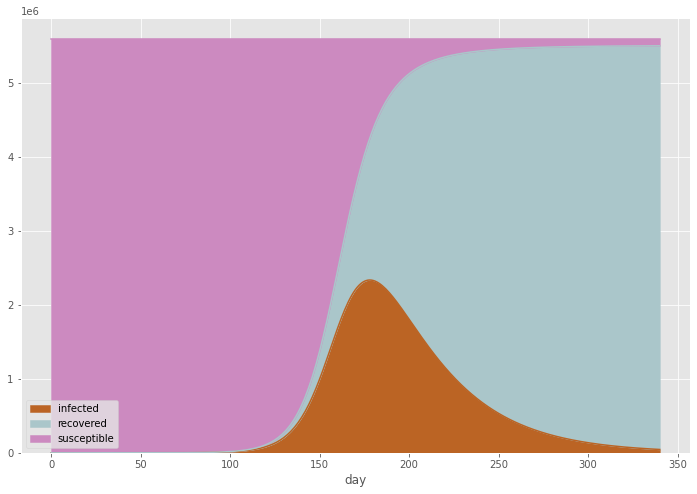

In [15]:
effective_contact_rate = 0.12449368129980964   #Paste beta from above
recovery_rate = 0.029903250991034625    #Paste gamma from above

# We'll compute this for fun
print("R0 is", effective_contact_rate / recovery_rate)

# What's our start population look like?
# Everyone not infected or recovered is susceptible
total_pop = 5600000
recovered = 0
infected = 1
susceptible = total_pop - infected - recovered

# A list of days, 0-160
days = range(0, 341)

# Use differential equations magic with our population
# We don't need to change this part of the codes.
ret = odeint(deriv,
             [susceptible, infected, recovered],
             days,
             args=(total_pop, effective_contact_rate, recovery_rate))
S, I, R = ret.T     # all three variables S, I, R store a list of the
                    #number of people in each case from day 0 to 159

# Build a dataframe because why not
df = pd.DataFrame({
    'day': days,
    'susceptible': S,
    'infected': I,
    'recovered': R
})

plt.style.use('ggplot')
df.plot(x='day',
        y=['infected', 'recovered', 'susceptible'],
        color=['#bb6424', '#aac6ca', '#cc8ac0'],
        kind='area',
        figsize=(12,8),
        stacked=True)    #Stacked area graph is plotted when stacked=True. 
                         #Change this to stacked=False to plot a non stacking graph.

# If you get the error:
#
#     When stacked is True, each column must be either all
#     positive or negative.infected contains both...
#
# just change stacked=True to stacked=False

In [19]:
df #Displaying data frame

writer = pd.ExcelWriter('Simulated SIR Data.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='SIR Simulation', index=False)
writer.save()

# **SEIR Model Trial**


In [38]:
def deriv(state, t, N, beta, sd, gamma):
    S, E, I, R = state
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in E population over time
    dEdt = beta * S * I / N - sd * E
    # Change in I population over time
    dIdt = sd * E - gamma * I
    # Change in R population over time
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

**Particle Swarm Optimization on SEIR**

In [63]:
import math
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

#=========Initialization=========
N = 5600000
recovered = 0
infected = 0
exposed = 1
susceptible = N - infected - recovered - exposed
MaxDays = 84

df=pd.read_excel('SG Data.xlsx')
I_data=df['Active cases (I)']
R_data=df['Removed (R)']
range_I = I_data[MaxDays-1]
range_R = R_data[MaxDays-1]

#=========The SEIR model differential equations.=========
def deriv(state, t, N, beta, sd, gamma):
    S, E, I, R = state
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in E population over time
    dEdt = beta * S * I / N - sd * E
    # Change in I population over time
    dIdt = sd * E - gamma * I
    # Change in R population over time
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

#=========Calculating E(p,q), or residual lost===============
def Surrogate_Loss_Func(beta, sd, gamma):
    
    # A list of days, 0~Iterations
    days = range(0, 200)

    ret = odeint(deriv,
             [susceptible, exposed, infected, recovered],
             days,
             args=(N, beta, sd, gamma))
    S, E, I, R = ret.T     # all three variables S, I, R store a list of the
                    #number of people in each case from day 0 to 159
    
    #Calculating ordinary least squares
    #Equalize the difference between I and R by standardizing them
    E_value=0
    for i in range(0,MaxDays):
        diff1=((I_data[i]/range_I)*1000 - (I[i]/range_I)*1000 )**2
        diff2=((R_data[i]/range_R)*1000 - (R[i]/range_R)*1000 )**2
        E_value = E_value+diff1+diff2

    return E_value*(10**(-6))

def Loss_Function(X):
    result=[]
    for i in range(len(X)):
        result.append(Surrogate_Loss_Func(X[i,0],X[i,1],X[i,2]))
    
    Loss = np.array(result)
    return Loss

#===========Main Function===========
def main():
    #Initialization
    effective_contact_rate = 0.1
    recovery_rate = 0.05
    incubation_rate = 1/4
    Initial_Lost = Surrogate_Loss_Func(effective_contact_rate,incubation_rate,recovery_rate)
    print("Initial beta:",effective_contact_rate)
    print("Initial sd:",incubation_rate)
    print("Initial gamma",recovery_rate)
    print("Initial Residual Lost:",Initial_Lost)
    MaxIters=1000
    
    # Create bounds
    max_bound = 0.5*np.ones(3)
    min_bound = 0*np.ones(3)
    bounds = (min_bound, max_bound)

    # Initialize swarm
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

    # Call instance of PSO with bounds argument
    optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=3, options=options, bounds=bounds)

    # Perform optimization
    cost, pos = optimizer.optimize(Loss_Function, MaxIters)
    
    print("\n=======The most fitting data:=====")
    print("Beta:",pos[0])
    print("Incubation rate:",pos[1])
    print("Gamma:",pos[2])
    print("R0 =", pos[0] / pos[2])
    print("Residual Loss:",cost)

main()

2021-01-16 16:15:10,002 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1000

Initial beta: 0.1
Initial sd: 0.25
Initial gamma 0.05
Initial Residual Lost: 12.560533084443868


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.563
2021-01-16 16:20:11,265 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5633859689561052, best pos: [0.15448981 0.49912444 0.02908595]



=======The most fitting data:=====
Beta: 0.15448980605572346
Incubation rate: 0.4991244430281043
Gamma: 0.029085949861216112
R0 = 5.311492552000985
Residual Loss: 0.5633859689561052


**Gradient descent on SEIR**

In [3]:
import math
#=========Initialization=========
N = 5600000
recovered = 0
infected = 0
exposed = 1
susceptible = N - infected - recovered - exposed
MaxDays = 84
STEP=10**(-8)         #The step to calculate the gradient of Loss_Func & 精度 to terminate iterations

df=pd.read_excel('SG Data.xlsx')
I_data=df['Active cases (I)']
R_data=df['Removed (R)']
range_I = I_data[MaxDays-1]
range_R = R_data[MaxDays-1]

#=========The SEIR model differential equations.=========
def deriv(state, t, N, beta, sd, gamma):
    S, E, I, R = state
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in E population over time
    dEdt = beta * S * I / N - sd * E
    # Change in I population over time
    dIdt = sd * E - gamma * I
    # Change in R population over time
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

#=========Calculating E(p,q), or residual lost===============
def Loss_Function(beta, sd, gamma):
    
    # A list of days, 0~Iterations
    days = range(0, 200)

    ret = odeint(deriv,
             [susceptible, exposed, infected, recovered],
             days,
             args=(N, beta, sd, gamma))
    S, E, I, R = ret.T     # all three variables S, I, R store a list of the
                    #number of people in each case from day 0 to 159
    
    #Calculating ordinary least squares
    #Equalize the difference between I and R by standardizing them
    E_value=0
    for i in range(0,MaxDays):
        diff1=((I_data[i]/range_I)*1000 - (I[i]/range_I)*1000 )**2
        diff2=((R_data[i]/range_R)*1000 - (R[i]/range_R)*1000 )**2
        E_value = E_value+diff1+diff2

    return E_value*(10**(-6))

#=======Finding the steepest gradient of Loss_Function=====
def Find_Nabla_F(beta, sd, gamma):
    nabla_beta = (Loss_Function(beta+STEP,sd,gamma)-Loss_Function(beta,sd,gamma))/STEP
    nabla_sd = (Loss_Function(beta,sd+STEP,gamma)-Loss_Function(beta,sd,gamma))/STEP
    nabla_gamma = (Loss_Function(beta,sd,gamma+STEP)-Loss_Function(beta,sd,gamma))/STEP
    return nabla_beta, nabla_sd, nabla_gamma     #Return nabla_F as a vector

#=======Determine the learning_rate in an iteration=======
#Learning_rate Annealing
def Find_LR(X,n,Max_LR):
    x0=X[n][0]-X[n-1][0]
    x1=X[n][1]-X[n-1][1]
    x2=X[n][2]-X[n-1][2]
    f1=Find_Nabla_F(X[n][0],X[n][1],X[n][2])
    f2=Find_Nabla_F(X[n-1][0],X[n-1][1],X[n][2])
    y0=f1[0]-f2[0]
    y1=f1[1]-f2[1]
    y2=f1[2]-f2[2]
    numerator = abs(x0*y0+x1*y1+x2*y2)
    denominator = y0*y0 + y1*y1 + y2*y2
    LR=numerator/denominator
    
    if LR < Max_LR:
        return LR
    else:
        return Max_LR

#===========Main Function===========
def main():
    #Initialization
    effective_contact_rate = 0.1
    recovery_rate = 0.05
    incubation_rate = 1/6
    Initial_Lost = Loss_Function(effective_contact_rate,incubation_rate,recovery_rate)
    print("Initial beta:",effective_contact_rate)
    print("Initial sd:",incubation_rate)
    print("Initial gamma",recovery_rate)
    print("Initial Residual Lost:",Initial_Lost)
    digit=int(math.log(Initial_Lost+1,10))+1
    learning_rate = Max_learning_rate = 10**(-5)
    MaxIters=2000
    
    #X[n][0] is the beta value at the nth iteration
    #X[n][1] is the sd value at the nth iteration
    #X[n][2] is the gamma value at the nth iteration
    X=[0]*(MaxIters+1)
    X[0]=[effective_contact_rate, incubation_rate, recovery_rate]
    for i in range(1,MaxIters+1):
        X[i]=[0,0,1]
    
    #Start Iterations for Gradient Descent
    n=0
    while n < MaxIters:
        nabla_beta, nabla_sd, nabla_gamma = Find_Nabla_F(X[n][0],X[n][1],X[n][2])
        X[n+1][0] = X[n][0] - learning_rate*nabla_beta
        X[n+1][1] = X[n][1] - learning_rate*nabla_sd
        X[n+1][2] = X[n][2] - learning_rate*nabla_gamma
        if n>0:
            learning_rate = Find_LR(X,n,Max_learning_rate)
        
        n+=1
        print("\nIteration",n)
        print("Gradient vector: (",nabla_beta,",", nabla_sd,",",nabla_gamma,")")
        print("Coordinates (beta,sd,gamma): (",X[n][0],",", X[n][1],",",X[n][2],")")
        print("Residual Lost:",Loss_Function(X[n][0], X[n][1], X[n][2]))
        print("Learning Rate, slope:",learning_rate, learning_rate*nabla_beta,
              learning_rate*nabla_sd, learning_rate*nabla_gamma)
        
        if abs(learning_rate*nabla_beta)<STEP and abs(learning_rate*nabla_gamma)<STEP \
                                            and abs(learning_rate*nabla_sd)<STEP:
            break
        if n==1000:
            Max_learning_rate/=10
        
        
    print("\n=======The most fitting data:=====")
    print("Beta:",X[n][0])
    print("Incubation rate:",X[n][1])
    print("Gamma:",X[n][2])
    print("R0 =", X[n][0] / X[n][2])
    print("The Ordinary Least Square value is:",Loss_Function(X[n][0], X[n][1], X[n][2]))
    print("Number of iterations:",n)

main()

Initial beta: 0.1
Initial sd: 0.16666666666666666
Initial gamma 0.05
Initial Residual Lost: 12.740961240341571

Iteration 1
Gradient vector: ( -12.52821846264851 , -2.406793164766441 , 8.393694983510613 )
Coordinates (beta,sd,gamma): ( 0.10012528218462649 , 0.16669073459831432 , 0.0499160630501649 )
Residual Lost: 12.738622273035519
Learning Rate, slope: 1e-05 -0.0001252821846264851 -2.4067931647664412e-05 8.393694983510615e-05

Iteration 2
Gradient vector: ( -12.600325938194601 , -2.4258596909021435 , 8.446063937128656 )
Coordinates (beta,sd,gamma): ( 0.10025128544400844 , 0.16671499319522334 , 0.04983160241079361 )
Residual Lost: 12.736255320244828
Learning Rate, slope: 1e-05 -0.000126003259381946 -2.4258596909021438e-05 8.446063937128657e-05

Iteration 3
Gradient vector: ( -12.67330436149905 , -2.445186630950502 , 8.499055859090276 )
Coordinates (beta,sd,gamma): ( 0.10037801848762343 , 0.16673944506153285 , 0.04974661185220271 )
Residual Lost: 12.73385987349773
Learning Rate, slope:


Iteration 27
Gradient vector: ( -14.733760345109204 , -3.0027123898435093 , 9.990623439648516 )
Coordinates (beta,sd,gamma): ( 0.10366430998255396 , 0.16739205804030158 , 0.047529516292615884 )
Residual Lost: 12.666247395240523
Learning Rate, slope: 1e-05 -0.00014733760345109204 -3.0027123898435096e-05 9.990623439648517e-05

Iteration 28
Gradient vector: ( -14.834855477374731 , -3.0306239295896376 , 10.063556921124928 )
Coordinates (beta,sd,gamma): ( 0.10381265853732771 , 0.16742236427959747 , 0.047428880723404634 )
Residual Lost: 12.662930317843289
Learning Rate, slope: 1e-05 -0.0001483485547737473 -3.030623929589638e-05 0.00010063556921124929

Iteration 29
Gradient vector: ( -14.937396386471846 , -3.05898470998045 , 10.137507189256212 )
Coordinates (beta,sd,gamma): ( 0.10396203250119243 , 0.16745295412669728 , 0.04732750565151207 )
Residual Lost: 12.65956579944424
Learning Rate, slope: 1e-05 -0.00014937396386471846 -3.05898470998045e-05 0.00010137507189256213

Iteration 30
Gradient 


Iteration 54
Gradient vector: ( -18.079889230193658 , -3.9509043148200362 , 12.39031135469304 )
Coordinates (beta,sd,gamma): ( 0.10807926550550065 , 0.16832549055025461 , 0.044518086152694994 )
Residual Lost: 12.55640233945449
Learning Rate, slope: 1e-05 -0.0001807988923019366 -3.950904314820036e-05 0.0001239031135469304

Iteration 55
Gradient vector: ( -18.234177900922077 , -3.9957507524945868 , 12.50020265075591 )
Coordinates (beta,sd,gamma): ( 0.10826160728450987 , 0.16836544805777956 , 0.044393084126187435 )
Residual Lost: 12.551333095557425
Learning Rate, slope: 1e-05 -0.0001823417790092208 -3.995750752494587e-05 0.0001250020265075591

Iteration 56
Gradient vector: ( -18.391185641064567 , -4.04148412513905 , 12.611957522778994 )
Coordinates (beta,sd,gamma): ( 0.10844551914092052 , 0.16840586289903095 , 0.044266964550959645 )
Residual Lost: 12.546174017884116
Learning Rate, slope: 1e-05 -0.0001839118564106457 -4.04148412513905e-05 0.00012611957522778994

Iteration 57
Gradient vect


Iteration 81
Gradient vector: ( -23.464691167873752 , -5.56594930145593 , 16.181964745953792 )
Coordinates (beta,sd,gamma): ( 0.11365074625070407 , 0.1695969617345933 , 0.04068486551934143 )
Residual Lost: 12.37909286974421
Learning Rate, slope: 1e-05 -0.00023464691167873755 -5.565949301455931e-05 0.00016181964745953792

Iteration 82
Gradient vector: ( -23.727442055587744 , -5.647149059484491 , 16.36458648590633 )
Coordinates (beta,sd,gamma): ( 0.11388802067125994 , 0.16965343322518814 , 0.04052121965448237 )
Residual Lost: 12.370416657405693
Learning Rate, slope: 1e-05 -0.00023727442055587747 -5.6471490594844915e-05 0.0001636458648590633

Iteration 83
Gradient vector: ( -23.996192766162494 , -5.730413299431802 , 16.55114019172288 )
Coordinates (beta,sd,gamma): ( 0.11412798259892157 , 0.16971073735818246 , 0.04035570825256514 )
Residual Lost: 12.361539591083645
Learning Rate, slope: 1e-05 -0.00023996192766162497 -5.730413299431803e-05 0.0001655114019172288

Iteration 84
Gradient vecto


Iteration 108
Gradient vector: ( -33.479756389453996 , -8.787900362960954 , 22.97500891756954 )
Coordinates (beta,sd,gamma): ( 0.12122935379489377 , 0.17149423007880196 , 0.035464793629930116 )
Residual Lost: 12.04627712941431
Learning Rate, slope: 1e-05 -0.00033479756389454 -8.787900362960956e-05 0.00022975008917569542

Iteration 109
Gradient vector: ( -34.01616961440368 , -8.966969922141743 , 23.328861153970593 )
Coordinates (beta,sd,gamma): ( 0.12156951549103781 , 0.17158389977802338 , 0.03523150501839041 )
Residual Lost: 12.028315135381892
Learning Rate, slope: 1e-05 -0.00034016169614403685 -8.966969922141745e-05 0.00023328861153970595

Iteration 110
Gradient vector: ( -34.5697554138269 , -9.152390845201808 , 23.692947515030482 )
Coordinates (beta,sd,gamma): ( 0.12191521304517608 , 0.1716754236864754 , 0.034994575543240106 )
Residual Lost: 12.00976163294465
Learning Rate, slope: 1e-05 -0.000345697554138269 -9.152390845201809e-05 0.00023692947515030485

Iteration 111
Gradient vecto


Iteration 135
Gradient vector: ( -57.6999052981364 , -17.358923543042692 , 37.86434135122363 )
Coordinates (beta,sd,gamma): ( 0.13309499448889142 , 0.1748470058176205 , 0.02747449822327326 )
Residual Lost: 11.21801852249213
Learning Rate, slope: 1e-05 -0.000576999052981364 -0.00017358923543042695 0.00037864341351223635

Iteration 136
Gradient vector: ( -59.24009620628112 , -17.93224306823049 , 38.73110276941816 )
Coordinates (beta,sd,gamma): ( 0.13368739545095423 , 0.1750263282483028 , 0.02708718719557908 )
Residual Lost: 11.16400277241874
Learning Rate, slope: 1e-05 -0.0005924009620628112 -0.00017932243068230494 0.00038731102769418163

Iteration 137
Gradient vector: ( -60.8580448258067 , -18.53761570913548 , 39.63044417076844 )
Coordinates (beta,sd,gamma): ( 0.1342959758992123 , 0.17521170440539416 , 0.026690882753871395 )
Residual Lost: 11.107064440398645
Learning Rate, slope: 1e-05 -0.000608580448258067 -0.00018537615709135483 0.00039630444170768447

Iteration 138
Gradient vector: 

Residual Lost: 7.80953952910699
Learning Rate, slope: 1e-05 -0.001413583509801697 -0.0005222525309989123 0.0005846516160090687

Iteration 162
Gradient vector: ( -146.38955470047676 , -54.62598453576106 , 55.77242108145697 )
Coordinates (beta,sd,gamma): ( 0.1585079344972428 , 0.1834813374361938 , 0.013472537067410431 )
Residual Lost: 7.531089212310297
Learning Rate, slope: 1e-05 -0.0014638955470047679 -0.0005462598453576106 0.0005577242108145697

Iteration 163
Gradient vector: ( -151.168453932371 , -56.976853990420295 , 51.93548053838981 )
Coordinates (beta,sd,gamma): ( 0.1600196190365665 , 0.184051105976098 , 0.012953182262026533 )
Residual Lost: 7.24036307626044
Learning Rate, slope: 1e-05 -0.0015116845393237102 -0.000569768539904203 0.0005193548053838981

Iteration 164
Gradient vector: ( -155.53548484703583 , -59.212039094092006 , 46.78759948362199 )
Coordinates (beta,sd,gamma): ( 0.16157497388503686 , 0.18464322636703892 , 0.012485306267190313 )
Residual Lost: 6.939285131481963
Lear


Iteration 187
Gradient vector: ( -78.50325416391968 , -34.655115532800096 , -49.713294592024226 )
Coordinates (beta,sd,gamma): ( 0.19274563311268714 , 0.1975453876191507 , 0.019557323682970223 )
Residual Lost: 1.363057228691606
Learning Rate, slope: 9.084869900984127e-06 -0.0007131918508831007 -0.0003148372160190631 -0.0004516388137178379

Iteration 188
Gradient vector: ( -73.124028188154 , -32.39555650402792 , -47.9662087382593 )
Coordinates (beta,sd,gamma): ( 0.19340995539541242 , 0.19783969703535978 , 0.01999309044900076 )
Residual Lost: 1.2863188612828576
Learning Rate, slope: 8.654296272453094e-06 -0.0006328370045754961 -0.00028036074389685244 -0.0004151137814872245

Iteration 189
Gradient vector: ( -68.2953269270925 , -30.357587443852196 , -46.22775040541427 )
Coordinates (beta,sd,gamma): ( 0.19400100338866352 , 0.19810242059121577 , 0.020393159097018228 )
Residual Lost: 1.2213340126195154
Learning Rate, slope: 8.27625303195122e-06 -0.0005652294065484491 -0.00025124707512490604 


Iteration 211
Gradient vector: ( -25.10235864727761 , -11.772392372044749 , -22.882493699860618 )
Coordinates (beta,sd,gamma): ( 0.1996741484198995 , 0.20068331115813814 , 0.0249052776885731 )
Residual Lost: 0.7707164810792164
Learning Rate, slope: 4.941903632764795e-06 -0.00012405343738994598 -5.817802862974051e-05 -0.00011308307874205872

Iteration 212
Gradient vector: ( -24.310555890583174 , -11.426007695547469 , -22.296755286532743 )
Coordinates (beta,sd,gamma): ( 0.1997942888443697 , 0.20073977738707677 , 0.025015466104522485 )
Residual Lost: 0.7647791625182804
Learning Rate, slope: 4.877612851256989e-06 -0.00011857747983310978 -5.573164197436359e-05 -0.00010875494012692432

Iteration 213
Gradient vector: ( -23.559731510136572 , -11.097354712941154 , -21.7347681408242 )
Coordinates (beta,sd,gamma): ( 0.1999092040935557 , 0.20079390598703956 , 0.02512147988892526 )
Residual Lost: 0.7592449749734784
Learning Rate, slope: 4.816485974894023e-06 -0.00011347511639084158 -5.345025333330


Iteration 236
Gradient vector: ( -13.036110624309316 , -6.470132885016966 , -13.131815612688058 )
Coordinates (beta,sd,gamma): ( 0.2016444478264435 , 0.20163072219150677 , 0.026798036830062037 )
Residual Lost: 0.6929303230902853
Learning Rate, slope: 3.932792747699003e-06 -5.12683213214856e-05 -2.5445691686843548e-05 -5.164470920570013e-05

Iteration 237
Gradient vector: ( -12.755190603730426 , -6.346056824479973 , -12.882157751636925 )
Coordinates (beta,sd,gamma): ( 0.20169461134754538 , 0.20165567991776256 , 0.02684869968664239 )
Residual Lost: 0.6914939122319225
Learning Rate, slope: 3.9084314218475785e-06 -4.9852787747274986e-05 -2.480312789762779e-05 -5.034903013769511e-05

Iteration 238
Gradient vector: ( -12.483225120263342 , -6.225908522061729 , -12.639396207436704 )
Coordinates (beta,sd,gamma): ( 0.2017434011768514 , 0.20168001345425973 , 0.026898099899932717 )
Residual Lost: 0.6901226394913129
Learning Rate, slope: 3.884815626651543e-06 -4.849502801820812e-05 -2.418650671660


Iteration 260
Gradient vector: ( -8.134939333270808 , -4.300986422567377 , -8.611091273369453 )
Coordinates (beta,sd,gamma): ( 0.20255599663599283 , 0.2020964923480207 , 0.027739877247237518 )
Residual Lost: 0.6710105929457824
Learning Rate, slope: 3.5013740808096636e-06 -2.8483465730473452e-05 -1.5059362381891692e-05 -3.0150651792062086e-05

Iteration 261
Gradient vector: ( -7.991174666432954 , -4.237214068503192 , -8.473031931632846 )
Coordinates (beta,sd,gamma): ( 0.2025839767278451 , 0.20211132841953502 , 0.02776954450162881 )
Residual Lost: 0.6704771867434978
Learning Rate, slope: 3.4885523130379853e-06 -2.787763086647523e-05 -1.4781742939513903e-05 -2.9558615143542475e-05

Iteration 262
Gradient vector: ( -7.850824812472013 , -4.174949674862205 , -8.337941259650705 )
Coordinates (beta,sd,gamma): ( 0.20261136474090388 , 0.2021258929498801 , 0.027798631845896142 )
Residual Lost: 0.6699630696182142
Learning Rate, slope: 3.4759435689335435e-06 -2.7289024017735984e-05 -1.451188947295


Iteration 284
Gradient vector: ( -5.440021233482639 , -3.1041476833415516 , -5.968776906062345 )
Coordinates (beta,sd,gamma): ( 0.20309301016481335 , 0.20239074267551713 , 0.028318610395783206 )
Residual Lost: 0.6622116276359614
Learning Rate, slope: 3.258305724398977e-06 -1.7725252325908466e-05 -1.01142621660116e-05 -1.9448099960683354e-05

Iteration 285
Gradient vector: ( -5.35461061046405 , -3.0661662209219287 , -5.883124520877914 )
Coordinates (beta,sd,gamma): ( 0.20311045712321735 , 0.2024007331824667 , 0.028337779414086935 )
Residual Lost: 0.661976517761829
Learning Rate, slope: 3.2505616645463618e-06 -1.7405491978947632e-05 -9.966762374855812e-06 -1.912345903531843e-05

Iteration 286
Gradient vector: ( -5.270857983408206 , -3.0289189156817997 , -5.79901753283707 )
Coordinates (beta,sd,gamma): ( 0.20312759037211747 , 0.20241057887017905 , 0.02835662947817121 )
Residual Lost: 0.6617487345614641
Learning Rate, slope: 3.2428790307848703e-06 -1.70927548286395e-05 -9.822417637612155e


Iteration 308
Gradient vector: ( -3.7727801993625576 , -2.3621957834230045 , -4.274975762275091 )
Coordinates (beta,sd,gamma): ( 0.2034378066332853 , 0.20259633694935408 , 0.028702934002420088 )
Residual Lost: 0.6581548005497003
Learning Rate, slope: 3.106573759760306e-06 -1.1720419968682976e-05 -7.3383354361983445e-06 -1.3280527526695109e-05

Iteration 309
Gradient vector: ( -3.7175777678477573 , -2.3376102165073576 , -4.218099014519083 )
Coordinates (beta,sd,gamma): ( 0.20344935556282878 , 0.20260359890791324 , 0.028716037838134662 )
Residual Lost: 0.6580403821656066
Learning Rate, slope: 3.101622177012938e-06 -1.153052164952686e-05 -7.250383688731235e-06 -1.3082949448268808e-05

Iteration 310
Gradient vector: ( -3.6633019062648486 , -2.3134356319509664 , -4.162126077122963 )
Coordinates (beta,sd,gamma): ( 0.20346071774126234 , 0.20261077431117439 , 0.02872894718067899 )
Residual Lost: 0.6579291697317944
Learning Rate, slope: 3.096499574567281e-06 -1.1343412794260614e-05 -7.16355245


Iteration 332
Gradient vector: ( -2.667644738441055 , -1.8697548065382819 , -3.1264312694290197 )
Coordinates (beta,sd,gamma): ( 0.20366987768213457 , 0.2027496902000637 , 0.028970205572978528 )
Residual Lost: 0.6561219320272894
Learning Rate, slope: 3.006234746990014e-06 -8.019566305326587e-06 -5.620921867766974e-06 -9.398786316233617e-06

Iteration 333
Gradient vector: ( -2.6300429833980843 , -1.8529914602716246 , -3.086983468847393 )
Coordinates (beta,sd,gamma): ( 0.20367778420873733 , 0.20275526072737743 , 0.02897948576994596 )
Residual Lost: 0.6560625379605551
Learning Rate, slope: 3.0030577913828064e-06 -7.898171072965298e-06 -5.564640442134506e-06 -9.270389757992087e-06

Iteration 334
Gradient vector: ( -2.593009906792787 , -1.8364805787207672 , -3.0481085655509332 )
Coordinates (beta,sd,gamma): ( 0.20368557116734107 , 0.20276077578468807 , 0.02898863941612272 )
Residual Lost: 0.6560046766225491
Learning Rate, slope: 2.9996455048679034e-06 -7.778110510988924e-06 -5.508790712736


Iteration 356
Gradient vector: ( -1.902140833731636 , -1.528358284375031 , -2.3185152131510733 )
Coordinates (beta,sd,gamma): ( 0.20383022268435202 , 0.20286970456455436 , 0.029161675214636036 )
Residual Lost: 0.6550441321905693
Learning Rate, slope: 2.938570444309137e-06 -5.5895748349173255e-06 -4.491188482779485e-06 -6.813120280046843e-06

Iteration 357
Gradient vector: ( -1.8756195818703247 , -1.5165261713079303 , -2.290342038246962 )
Coordinates (beta,sd,gamma): ( 0.20383573432462007 , 0.2028741609835394 , 0.029168405546056986 )
Residual Lost: 0.6550118112929713
Learning Rate, slope: 2.9362096636958286e-06 -5.5072123417047765e-06 -4.452838799441981e-06 -6.724924425869531e-06

Iteration 358
Gradient vector: ( -1.8494658915457762 , -1.5048581158971785 , -2.262546427989065 )
Coordinates (beta,sd,gamma): ( 0.2038411647442435 , 0.2028785795624818 , 0.029175048856743407 )
Residual Lost: 0.6549802726163988
Learning Rate, slope: 2.934037614647518e-06 -5.426402492802915e-06 -4.415310316749


Iteration 381
Gradient vector: ( -1.3367399964714366 , -1.2760512757559184 , -1.7151908560109064 )
Coordinates (beta,sd,gamma): ( 0.2039462815688681 , 0.2029710041193298 , 0.029306592784251018 )
Residual Lost: 0.6544292028851592
Learning Rate, slope: 2.8914235619910863e-06 -3.865081522053394e-06 -3.6896047250294474e-06 -4.959343254381596e-06

Iteration 382
Gradient vector: ( -1.3178263369439946 , -1.2676085403562354 , -1.6949104342245391 )
Coordinates (beta,sd,gamma): ( 0.20395009196298935 , 0.20297466931253078 , 0.029311493488216 )
Residual Lost: 0.6544113278157941
Learning Rate, slope: 2.8899448266811545e-06 -3.8084454049154734e-06 -3.663318743459352e-06 -4.898197641075116e-06

Iteration 383
Gradient vector: ( -1.299156415779379 , -1.259274984288794 , -1.6748858633341968 )
Coordinates (beta,sd,gamma): ( 0.20395384645335218 , 0.202978308547757 , 0.029316333815952025 )
Residual Lost: 0.6543938565194012
Learning Rate, slope: 2.8881853317869677e-06 -3.7522045037509334e-06 -3.63701953830


Iteration 407
Gradient vector: ( -0.9161812086766474 , -1.0882906686937588 , -1.2627341394733094 )
Coordinates (beta,sd,gamma): ( 0.20402903940148417 , 0.20305872622347892 , 0.029416357536386897 )
Residual Lost: 0.6540727994790843
Learning Rate, slope: 2.86004156449457e-06 -2.620316337424085e-06 -3.1125565467157396e-06 -3.6114721237999483e-06

Iteration 408
Gradient vector: ( -0.9026120517674485 , -1.0822319929104651 , -1.248083469906902 )
Coordinates (beta,sd,gamma): ( 0.20403162090946883 , 0.20306182145196108 , 0.02941992710698679 )
Residual Lost: 0.6540627159972908
Learning Rate, slope: 2.8590021751708533e-06 -2.5805698193385623e-06 -3.0941036217705074e-06 -3.5682733552586193e-06

Iteration 409
Gradient vector: ( -0.8892108716018754 , -1.076247546638598 , -1.2336104804333559 )
Coordinates (beta,sd,gamma): ( 0.20403416316528492 , 0.20306489844603795 , 0.029423454002033663 )
Residual Lost: 0.6540528432202137
Learning Rate, slope: 2.8582629174680758e-06 -2.541598460109107e-06 -3.07619


Iteration 432
Gradient vector: ( -0.6223851989339835 , -0.9570756742682818 , -0.944759659393668 )
Coordinates (beta,sd,gamma): ( 0.20408293545417752 , 0.20313120693478182 , 0.029494027360690327 )
Residual Lost: 0.6538735044401782
Learning Rate, slope: 2.8437063630126575e-06 -1.7698807504534674e-06 -2.7216421848013423e-06 -2.6866190549354447e-06

Iteration 433
Gradient vector: ( -0.6123880624819833 , -0.9526091915290635 , -0.933912591705166 )
Coordinates (beta,sd,gamma): ( 0.20408467690600743 , 0.20313391587560123 , 0.029496683133869855 )
Residual Lost: 0.6538674053175482
Learning Rate, slope: 2.8437934016699415e-06 -1.741505131347704e-06 -2.7090237332404886e-06 -2.655854466027625e-06

Iteration 434
Gradient vector: ( -0.6025137611054276 , -0.9481983864745303 , -0.9231958975064458 )
Coordinates (beta,sd,gamma): ( 0.20408639033066567 , 0.20313661235591615 , 0.029499308512271633 )
Residual Lost: 0.6538614199073391
Learning Rate, slope: 2.843479485428626e-06 -1.7132355193917277e-06 -2.696


Iteration 456
Gradient vector: ( -0.41251994042923457 , -0.8633089576548514 , -0.7166494619958996 )
Coordinates (beta,sd,gamma): ( 0.20411758100967567 , 0.203192980905797 , 0.02954998001769929 )
Residual Lost: 0.6537539466522185
Learning Rate, slope: 2.8399166940059867e-06 -1.1715222654353384e-06 -2.45172552092892e-06 -2.0352247708725645e-06

Iteration 457
Gradient vector: ( -0.404999977998699 , -0.85994826815039 , -0.708460479170725 )
Coordinates (beta,sd,gamma): ( 0.20411873117587426 , 0.2031954230872397 , 0.02955199198644113 )
Residual Lost: 0.6537499712714605
Learning Rate, slope: 2.839487628088139e-06 -1.1499924269032743e-06 -2.4418124682088537e-06 -2.011664765594668e-06

Iteration 458
Gradient vector: ( -0.39756774539156936 , -0.8566276799015782 , -0.7003647439773886 )
Coordinates (beta,sd,gamma): ( 0.20411986006456861 , 0.20319785547093866 , 0.029553980663466803 )
Residual Lost: 0.6537460616328934
Learning Rate, slope: 2.8390633041468746e-06 -1.1287199968536123e-06 -2.432020211


Iteration 482
Gradient vector: ( -0.2428048317959508 , -0.7874498275661779 , -0.5315652251702829 )
Coordinates (beta,sd,gamma): ( 0.20414122972392187 , 0.20325370598069595 , 0.029595481173927667 )
Residual Lost: 0.6536683317411239
Learning Rate, slope: 2.845885530787997e-06 -6.909947576135097e-07 -2.2409920704920885e-06 -1.5127737829821717e-06

Iteration 483
Gradient vector: ( -0.23723770725680993 , -0.7849602412512979 , -0.525485077673693 )
Coordinates (beta,sd,gamma): ( 0.2041419048752803 , 0.20325593988768878 , 0.029596976644306865 )
Residual Lost: 0.6536656409457271
Learning Rate, slope: 2.8461893010747244e-06 -6.752234242058299e-07 -2.2341454404184788e-06 -1.4956300059492855e-06

Iteration 484
Gradient vector: ( -0.2317348757330251 , -0.7824997427796632 , -0.5194742858094514 )
Coordinates (beta,sd,gamma): ( 0.2041425644366043 , 0.20325816703008479 , 0.02959845516646132 )
Residual Lost: 0.65366298586189
Learning Rate, slope: 2.8478667092832166e-06 -6.599500379799653e-07 -2.2284549


Iteration 506
Gradient vector: ( -0.1252619230562857 , -0.7348801678297434 , -0.40304348747355334 )
Coordinates (beta,sd,gamma): ( 0.20415347603948772 , 0.20330566281510462 , 0.029627090889952832 )
Residual Lost: 0.653612097453648
Learning Rate, slope: 2.8624807568501862e-06 -3.5855984431466646e-07 -2.103580339003476e-06 -1.1537042270668356e-06

Iteration 507
Gradient vector: ( -0.12102309154826685 , -0.7329830298274942 , -0.3984029994796856 )
Coordinates (beta,sd,gamma): ( 0.20415382246575842 , 0.2033077609649226 , 0.029628231310872315 )
Residual Lost: 0.6536100683284632
Learning Rate, slope: 2.8644046687911606e-06 -3.466591084623956e-07 -2.099560012782565e-06 -1.1411874117700137e-06

Iteration 508
Gradient vector: ( -0.11683318756894323 , -0.7311078520366721 , -0.39381493621704067 )
Coordinates (beta,sd,gamma): ( 0.20415415712328636 , 0.20330985515366734 , 0.029629359356214253 )
Residual Lost: 0.6536080588542351
Learning Rate, slope: 2.86651493017461e-06 -3.3490407650626643e-07 -2.0


Iteration 532
Gradient vector: ( -0.02913360663825415 , -0.6918532524657905 , -0.2977126767333971 )
Coordinates (beta,sd,gamma): ( 0.20415893322563788 , 0.20335889707387284 , 0.02965295923278144 )
Residual Lost: 0.6535648461559047
Learning Rate, slope: 2.8969939092457876e-06 -8.439988098538492e-08 -2.0042946584852833e-06 -8.624718112019114e-07

Iteration 533
Gradient vector: ( -0.025965285477269617 , -0.6904343763380894 , -0.2942373344971827 )
Coordinates (beta,sd,gamma): ( 0.20415900844691176 , 0.2033608972580558 , 0.02965381163654735 )
Residual Lost: 0.6535632152090001
Learning Rate, slope: 2.8995465840651003e-06 -7.528755480989228e-08 -2.0019466374322247e-06 -8.531548581457264e-07

Iteration 534
Gradient vector: ( -0.02283050415385901 , -0.6890305326301416 , -0.2907983964739458 )
Coordinates (beta,sd,gamma): ( 0.2041590746450221 , 0.203362895134183 , 0.0296546548200445 )
Residual Lost: 0.6535615946530191
Learning Rate, slope: 2.902296890728095e-06 -6.626090121949986e-08 -1.99977117


Iteration 557
Gradient vector: ( 0.04048464896655446 , -0.6606575730927489 , -0.22128783250252582 )
Coordinates (beta,sd,gamma): ( 0.2041582929679957 , 0.2034081829159084 , 0.029671663414690325 )
Residual Lost: 0.6535267728679456
Learning Rate, slope: 2.9480141170157818e-06 1.1934931667583094e-07 -1.9476278519908093e-06 -6.523596541412698e-07

Iteration 558
Gradient vector: ( 0.04289095745235727 , -0.659577614747775 , -0.21864288157757983 )
Coordinates (beta,sd,gamma): ( 0.20415816652484764 , 0.20341012736002795 , 0.029672307976991802 )
Residual Lost: 0.6535253456117607
Learning Rate, slope: 2.9540593281801784e-06 1.2670243295671514e-07 -1.948431405504497e-06 -6.458840438644438e-07

Iteration 559
Gradient vector: ( 0.04526883312649943 , -0.6585116785196021 , -0.2160303713694134 )
Coordinates (beta,sd,gamma): ( 0.20415803279802885 , 0.2034120726425946 , 0.029672946143525517 )
Residual Lost: 0.6535239222805792
Learning Rate, slope: 2.9552661175638924e-06 1.337814487203977e-07 -1.9460772


Iteration 581
Gradient vector: ( 0.09156655433883998 , -0.6377312344874042 , -0.16511766398608074 )
Coordinates (beta,sd,gamma): ( 0.20415339718564188 , 0.2034546372407726 , 0.02968533065562887 )
Residual Lost: 0.6534937150915681
Learning Rate, slope: 3.0325932827761113e-06 2.776841176149199e-07 -1.933979457923019e-06 -5.007347186718715e-07

Iteration 582
Gradient vector: ( 0.09342064899442448 , -0.6368974903026015 , -0.16307556416350621 )
Coordinates (beta,sd,gamma): ( 0.20415311387880927 , 0.2034565686918235 , 0.029685825197489336 )
Residual Lost: 0.6534923787959561
Learning Rate, slope: 3.042698092536107e-06 2.842508304988206e-07 -1.937886778884759e-06 -4.961897080195499e-07

Iteration 583
Gradient vector: ( 0.09525581434743913 , -0.6360729165599821 , -0.16105743405603334 )
Coordinates (beta,sd,gamma): ( 0.20415282404412466 , 0.20345850406967342 , 0.029686315246636726 )
Residual Lost: 0.6534910421588329
Learning Rate, slope: 3.0395698856162457e-06 2.895367047203279e-07 -1.933388082


Iteration 606
Gradient vector: ( 0.1324356402321314 , -0.619347173547169 , -0.1201003407835799 )
Coordinates (beta,sd,gamma): ( 0.2041446010302524 , 0.20350312543525365 , 0.02969618824615361 )
Residual Lost: 0.6534607443593682
Learning Rate, slope: 3.163844987350928e-06 4.190058364950398e-07 -1.9595184504571757e-06 -3.799788611672675e-07

Iteration 607
Gradient vector: ( 0.13385871300286567 , -0.618706519350809 , -0.1185305520401414 )
Coordinates (beta,sd,gamma): ( 0.20414417752203426 , 0.20350508292677352 , 0.02969656325844653 )
Residual Lost: 0.6534594326747644
Learning Rate, slope: 3.1675544787950635e-06 4.2400476589797013e-07 -1.9597866064293595e-06 -3.7545198098880125e-07

Iteration 608
Gradient vector: ( 0.13526493258808614 , -0.6180716494164074 , -0.11698098045798133 )
Coordinates (beta,sd,gamma): ( 0.2041437490629912 , 0.20350704070239484 , 0.029696933802075113 )
Residual Lost: 0.6534581218801329
Learning Rate, slope: 3.1817132007625833e-06 4.303742216157746e-07 -1.96652672596


Iteration 630
Gradient vector: ( 0.1627071255505541 , -0.6056850576641182 , -0.08669194251353929 )
Coordinates (beta,sd,gamma): ( 0.20413297120538024 , 0.2035508875061161 , 0.029704137400076987 )
Residual Lost: 0.6534289741746034
Learning Rate, slope: 3.3610383339486597e-06 5.468648861820098e-07 -2.0357306971090056e-06 -2.913749420324791e-07

Iteration 631
Gradient vector: ( 0.16381421774624982 , -0.6051838141729604 , -0.08546843233148138 )
Coordinates (beta,sd,gamma): ( 0.20413242061951475 , 0.20355292155211463 , 0.029704424662754397 )
Residual Lost: 0.6534276288123056
Learning Rate, slope: 3.3908119793238564e-06 5.554632119175505e-07 -2.052064526790577e-06 -2.8980738420361747e-07

Iteration 632
Gradient vector: ( 0.16490553367276561 , -0.6046904421630472 , -0.08426229713975886 )
Coordinates (beta,sd,gamma): ( 0.2041318614558557 , 0.2035549719437097 , 0.029704710380360943 )
Residual Lost: 0.6534262730294428
Learning Rate, slope: 3.3803689887322198e-06 5.574415520977538e-07 -2.0440768

Residual Lost: 0.6533955542274524
Learning Rate, slope: 3.7735872377022135e-06 7.032682768974701e-07 -2.2451147908235913e-06 -2.2837088064084386e-07

Iteration 655
Gradient vector: ( 0.18724000128145235 , -0.5945579029109638 , -0.05954957638110159 )
Coordinates (beta,sd,gamma): ( 0.20411743272368754 , 0.2036037648579938 , 0.029710467899246345 )
Residual Lost: 0.6533940748394138
Learning Rate, slope: 3.753668621787832e-06 7.028369175537011e-07 -2.231773343992861e-06 -2.2352937630249882e-07

Iteration 656
Gradient vector: ( 0.18811411317543048 , -0.5941600766945498 , -0.05858191709506855 )
Coordinates (beta,sd,gamma): ( 0.2041167266056436 , 0.20360599513803002 , 0.02971068779635035 )
Residual Lost: 0.6533926042258701
Learning Rate, slope: 3.783615987902927e-06 7.117515661607394e-07 -2.2480735655551283e-06 -2.2165147812290516e-07

Iteration 657
Gradient vector: ( 0.1889710832259084 , -0.5937692115765003 , -0.05763258759117207 )
Coordinates (beta,sd,gamma): ( 0.20411601161163184 , 0.203608


Iteration 679
Gradient vector: ( 0.20601886863147456 , -0.5859721707857091 , -0.038699565774180655 )
Coordinates (beta,sd,gamma): ( 0.20409809408436158 , 0.203661478257473 , 0.029715166367832977 )
Residual Lost: 0.6533559854270593
Learning Rate, slope: 4.540035509243648e-06 9.353329791610968e-07 -2.6603344627957024e-06 -1.756974028070903e-07

Iteration 680
Gradient vector: ( 0.2067183757503699 , -0.5856500617795746 , -0.03792234304356157 )
Coordinates (beta,sd,gamma): ( 0.20409715557559527 , 0.20366413712954948 , 0.029715338536616988 )
Residual Lost: 0.6533542279198765
Learning Rate, slope: 4.595171538366338e-06 9.499063967054178e-07 -2.6911624953319884e-06 -1.742596714219388e-07

Iteration 681
Gradient vector: ( 0.20741603989904434 , -0.585329074098695 , -0.03714394347653638 )
Coordinates (beta,sd,gamma): ( 0.20409620246331212 , 0.20366682681705137 , 0.029715509219408874 )
Residual Lost: 0.6533524497348216
Learning Rate, slope: 4.627484653336904e-06 9.598145414887427e-07 -2.708601307


Iteration 704
Gradient vector: ( 0.222583806941401 , -0.5782811451915393 , -0.020190549232523836 )
Coordinates (beta,sd,gamma): ( 0.20406822034729058 , 0.2037421409225162 , 0.0297190804483215 )
Residual Lost: 0.6533025218687473
Learning Rate, slope: 7.280435295139504e-06 1.6205070041826933e-06 -4.2101384599661745e-06 -1.4699598726071836e-07

Iteration 705
Gradient vector: ( 0.22323479731412021 , -0.5779742795475329 , -0.01945967831318285 )
Coordinates (beta,sd,gamma): ( 0.2040665951007931 , 0.20374634882686068 , 0.029719222123250323 )
Residual Lost: 0.6532997244899169
Learning Rate, slope: 7.636402331612343e-06 1.7047107267065562e-06 -4.413644135948744e-06 -1.4860193284321565e-07

Iteration 706
Gradient vector: ( 0.2238713103785983 , -0.5776738198903786 , -0.01874157495862505 )
Coordinates (beta,sd,gamma): ( 0.20406488552939656 , 0.20375076017656582 , 0.029719365241457036 )
Residual Lost: 0.6532967910267262
Learning Rate, slope: 7.965020980880218e-06 1.7831396841826829e-06 -4.60118409


Iteration 731
Gradient vector: ( 0.23708861540683301 , -0.5712224027121238 , -0.003669853310128701 )
Coordinates (beta,sd,gamma): ( 0.20400852333246766 , 0.20389031240883387 , 0.02972174275722295 )
Residual Lost: 0.6532036191955345
Learning Rate, slope: 1e-05 2.37088615406833e-06 -5.7122240271212385e-06 -3.669853310128701e-08

Iteration 732
Gradient vector: ( 0.23739824550617072 , -0.5710620532006772 , -0.0033059999182682986 )
Coordinates (beta,sd,gamma): ( 0.2040061493500126 , 0.20389602302936588 , 0.029721775817222133 )
Residual Lost: 0.6531997946509943
Learning Rate, slope: 1e-05 2.3739824550617072e-06 -5.710620532006772e-06 -3.3059999182682986e-08

Iteration 733
Gradient vector: ( 0.23769781698490533 , -0.570904656882476 , -0.002956168643208912 )
Coordinates (beta,sd,gamma): ( 0.20400377237184275 , 0.2039017320759347 , 0.029721805378908565 )
Residual Lost: 0.6531959704991076
Learning Rate, slope: 1e-05 2.3769781698490533e-06 -5.709046568824761e-06 -2.956168643208912e-08

Iteration


Iteration 756
Gradient vector: ( 0.2419048739099594 , -0.5684822834695069 , 0.002187916514628796 )
Coordinates (beta,sd,gamma): ( 0.20394851542649006 , 0.20403271320954058 , 0.0297217782921313 )
Residual Lost: 0.6531081084372902
Learning Rate, slope: 1e-05 2.419048739099594e-06 -5.68482283469507e-06 2.1879165146287963e-08

Iteration 757
Gradient vector: ( 0.24200620396541694 , -0.5684143711270906 , 0.002319922032256727 )
Coordinates (beta,sd,gamma): ( 0.2039460953644504 , 0.20403839735325185 , 0.029721755092910977 )
Residual Lost: 0.6531042920183928
Learning Rate, slope: 1e-05 2.4200620396541694e-06 -5.684143711270907e-06 2.3199220322567274e-08

Iteration 758
Gradient vector: ( 0.2421017275544557 , -0.5683475579054686 , 0.0024487190053434915 )
Coordinates (beta,sd,gamma): ( 0.20394367434717486 , 0.2040440808288309 , 0.029721730605720923 )
Residual Lost: 0.6531004758888249
Learning Rate, slope: 1e-05 2.421017275544557e-06 -5.683475579054687e-06 2.448719005343492e-08

Iteration 759
Grad


Iteration 782
Gradient vector: ( 0.24336456183604582 , -0.5672061709205423 , 0.00437829772437226 )
Coordinates (beta,sd,gamma): ( 0.2038853786523479 , 0.20418032674515768 , 0.02972086502600191 )
Residual Lost: 0.6530089730232564
Learning Rate, slope: 1e-05 2.4336456183604582e-06 -5.6720617092054235e-06 4.3782977243722605e-08

Iteration 783
Gradient vector: ( 0.24338675519430808 , -0.567173019661027 , 0.004424394184354696 )
Coordinates (beta,sd,gamma): ( 0.20388294478479596 , 0.2041859984753543 , 0.029720820782060068 )
Residual Lost: 0.6530051638532944
Learning Rate, slope: 1e-05 2.433867551943081e-06 -5.67173019661027e-06 4.424394184354697e-08

Iteration 784
Gradient vector: ( 0.24340617299500877 , -0.5671404457174845 , 0.0044683146072088675 )
Coordinates (beta,sd,gamma): ( 0.203880510723066 , 0.20419166987981147 , 0.029720776098913996 )
Residual Lost: 0.6530013549555594
Learning Rate, slope: 1e-05 2.4340617299500877e-06 -5.671404457174845e-06 4.468314607208868e-08

Iteration 785
Grad

Residual Lost: 0.6529100230995176
Learning Rate, slope: 1e-05 2.43528364141099e-06 -5.665054869652409e-06 5.142253289847077e-08

Iteration 809
Gradient vector: ( 0.24352203586985866 , -0.5664855251552581 , 0.005158595772769559 )
Coordinates (beta,sd,gamma): ( 0.2038196309267507 , 0.2043333639612795 , 0.029719554910763394 )
Residual Lost: 0.6529062209982907
Learning Rate, slope: 1e-05 2.4352203586985866e-06 -5.664855251552582e-06 5.158595772769559e-08

Iteration 810
Gradient vector: ( 0.24351637373243307 , -0.566463476125989 , 0.005173050876550178 )
Coordinates (beta,sd,gamma): ( 0.20381719576301338 , 0.20433902859604075 , 0.02971950318025463 )
Residual Lost: 0.6529024191705501
Learning Rate, slope: 1e-05 2.4351637373243307e-06 -5.664634761259891e-06 5.173050876550179e-08

Iteration 811
Gradient vector: ( 0.243509157282773 , -0.5664416380390946 , 0.005188616203355423 )
Coordinates (beta,sd,gamma): ( 0.20381476067144055 , 0.20434469301242114 , 0.029719451294092595 )
Residual Lost: 0.6528

Residual Lost: 0.6528112565361021
Learning Rate, slope: 1e-05 2.432359202941825e-06 -5.660079516189854e-06 5.405242919920284e-08

Iteration 835
Gradient vector: ( 0.24322192038184198 , -0.5659906321398012 , 0.005410172310149619 )
Coordinates (beta,sd,gamma): ( 0.20375635044933704 , 0.20448058095820582 , 0.02971817393842691 )
Residual Lost: 0.6528074614726476
Learning Rate, slope: 1e-05 2.43221920381842e-06 -5.6599063213980125e-06 5.41017231014962e-08

Iteration 836
Gradient vector: ( 0.243205555694459 , -0.5659732349450053 , 0.0054145132821759034 )
Coordinates (beta,sd,gamma): ( 0.2037539183937801 , 0.20448624069055527 , 0.029718119793294088 )
Residual Lost: 0.6528036666823308
Learning Rate, slope: 1e-05 2.43205555694459e-06 -5.659732349450054e-06 5.414513282175904e-08

Iteration 837
Gradient vector: ( 0.2431906231947778 , -0.5659558044435187 , 0.005420874860107006 )
Coordinates (beta,sd,gamma): ( 0.20375148648754815 , 0.2044919002485997 , 0.029718065584545487 )
Residual Lost: 0.652799


Iteration 861
Gradient vector: ( 0.2427671175198043 , -0.5655645618496408 , 0.005491940235913262 )
Coordinates (beta,sd,gamma): ( 0.20369317240909324 , 0.2046276802080978 , 0.029716754189996978 )
Residual Lost: 0.6527088846377657
Learning Rate, slope: 1e-05 2.427671175198043e-06 -5.6556456184964085e-06 5.4919402359132625e-08

Iteration 862
Gradient vector: ( 0.24274785515032704 , -0.5655494517142756 , 0.0054928506187934545 )
Coordinates (beta,sd,gamma): ( 0.20369074493054173 , 0.20463333570261494 , 0.02971669926149079 )
Residual Lost: 0.6527050968614152
Learning Rate, slope: 1e-05 2.4274785515032704e-06 -5.655494517142757e-06 5.492850618793455e-08

Iteration 863
Gradient vector: ( 0.2427279932604165 , -0.5655347190547388 , 0.005494082966350788 )
Coordinates (beta,sd,gamma): ( 0.20368831765060913 , 0.20463899104980549 , 0.029716644320661127 )
Residual Lost: 0.6527013093512876
Learning Rate, slope: 1e-05 2.427279932604165e-06 -5.655347190547389e-06 5.494082966350789e-08

Iteration 864
G

Residual Lost: 0.65261049001455
Learning Rate, slope: 1e-05 2.4225942363287345e-06 -5.65164215426961e-06 5.514677603457586e-08

Iteration 888
Gradient vector: ( 0.24224046102361285 , -0.5651483281354786 , 0.005514744216839063 )
Coordinates (beta,sd,gamma): ( 0.20362769847703943 , 0.20478032405244 , 0.029715267427395057 )
Residual Lost: 0.6526067092350656
Learning Rate, slope: 1e-05 2.4224046102361285e-06 -5.651483281354786e-06 5.514744216839063e-08

Iteration 889
Gradient vector: ( 0.2422200218177295 , -0.5651331957956529 , 0.005515132794897681 )
Coordinates (beta,sd,gamma): ( 0.20362527627682125 , 0.20478597538439797 , 0.029715212276067108 )
Residual Lost: 0.6526029287250242
Learning Rate, slope: 1e-05 2.422200218177295e-06 -5.65133195795653e-06 5.515132794897682e-08

Iteration 890
Gradient vector: ( 0.24220028205235167 , -0.5651173640153218 , 0.005514999568134726 )
Coordinates (beta,sd,gamma): ( 0.20362285427400073 , 0.20479162655803812 , 0.029715157126071427 )
Residual Lost: 0.65259


Iteration 913
Gradient vector: ( 0.2417349209693498 , -0.5647696643684696 , 0.00551516610158842 )
Coordinates (beta,sd,gamma): ( 0.20356720400705053 , 0.20492156181115068 , 0.029713888470779496 )
Residual Lost: 0.6525122771662935
Learning Rate, slope: 1e-05 2.417349209693498e-06 -5.647696643684697e-06 5.515166101588421e-08

Iteration 914
Gradient vector: ( 0.24171529222627441 , -0.5647546430509465 , 0.005515177203818666 )
Coordinates (beta,sd,gamma): ( 0.20356478685412827 , 0.20492720935758119 , 0.029713833319007458 )
Residual Lost: 0.6525085033730751
Learning Rate, slope: 1e-05 2.417152922262744e-06 -5.6475464305094655e-06 5.515177203818667e-08

Iteration 915
Gradient vector: ( 0.2416939981486621 , -0.5647397327557258 , 0.005515410350653838 )
Coordinates (beta,sd,gamma): ( 0.20356236991414678 , 0.20493285675490874 , 0.02971377816490395 )
Residual Lost: 0.6525047298496344
Learning Rate, slope: 1e-05 2.416939981486621e-06 -5.647397327557258e-06 5.515410350653838e-08

Iteration 916
Grad


Iteration 940
Gradient vector: ( 0.24118492758518073 , -0.5643642220221068 , 0.005509348532939384 )
Coordinates (beta,sd,gamma): ( 0.20350201259034117 , 0.20507399288891076 , 0.02971240015331023 )
Residual Lost: 0.652410478853692
Learning Rate, slope: 1e-05 2.4118492758518073e-06 -5.643642220221069e-06 5.509348532939385e-08

Iteration 941
Gradient vector: ( 0.24116515451311216 , -0.564348634490841 , 0.005508982159341258 )
Coordinates (beta,sd,gamma): ( 0.20349960093879604 , 0.20507963637525567 , 0.029712345063488636 )
Residual Lost: 0.652406712297849
Learning Rate, slope: 1e-05 2.4116515451311216e-06 -5.643486344908411e-06 5.508982159341259e-08

Iteration 942
Gradient vector: ( 0.24114378271988812 , -0.5643342571026722 , 0.005508360434447468 )
Coordinates (beta,sd,gamma): ( 0.20349718950096884 , 0.2050852797178267 , 0.02971228997988429 )
Residual Lost: 0.6524029460084816
Learning Rate, slope: 1e-05 2.4114378271988812e-06 -5.643342571026722e-06 5.5083604344474686e-08

Iteration 943
Gra


Iteration 967
Gradient vector: ( 0.24063332437762597 , -0.5639611777574771 , 0.005499722899315884 )
Coordinates (beta,sd,gamma): ( 0.2034369699454045 , 0.2052263147266094 , 0.029710914048626472 )
Residual Lost: 0.6523088756135451
Learning Rate, slope: 1e-05 2.4063332437762597e-06 -5.639611777574772e-06 5.499722899315885e-08

Iteration 968
Gradient vector: ( 0.24061289627397286 , -0.5639449573990873 , 0.005499567468092437 )
Coordinates (beta,sd,gamma): ( 0.20343456381644176 , 0.2052319541761834 , 0.02971085905295179 )
Residual Lost: 0.6523051162733368
Learning Rate, slope: 1e-05 2.4061289627397286e-06 -5.639449573990874e-06 5.4995674680924373e-08

Iteration 969
Gradient vector: ( 0.24059296777068084 , -0.5639311240202005 , 0.005498790311975199 )
Coordinates (beta,sd,gamma): ( 0.20343215788676405 , 0.2052375934874236 , 0.02971080406504867 )
Residual Lost: 0.6523013571925544
Learning Rate, slope: 1e-05 2.4059296777068084e-06 -5.639311240202006e-06 5.4987903119752e-08

Iteration 970
Gradi


Iteration 993
Gradient vector: ( 0.24010377019934026 , -0.563571411760222 , 0.005489919630008444 )
Coordinates (beta,sd,gamma): ( 0.2033744767933069 , 0.20537289193697866 , 0.029709485447833254 )
Residual Lost: 0.6522112193588128
Learning Rate, slope: 1e-05 2.4010377019934026e-06 -5.6357141176022205e-06 5.489919630008445e-08

Iteration 994
Gradient vector: ( 0.24008255383733967 , -0.5635573785411907 , 0.005489431131877609 )
Coordinates (beta,sd,gamma): ( 0.20337207596776852 , 0.20537852751076408 , 0.029709430553521935 )
Residual Lost: 0.6522074669440001
Learning Rate, slope: 1e-05 2.4008255383733967e-06 -5.635573785411908e-06 5.4894311318776097e-08

Iteration 995
Gradient vector: ( 0.24006200360915386 , -0.5635419797478392 , 0.005489086962739975 )
Coordinates (beta,sd,gamma): ( 0.20336967534773243 , 0.20538416293056155 , 0.029709375662652308 )
Residual Lost: 0.6522037147984204
Learning Rate, slope: 1e-05 2.4006200360915386e-06 -5.635419797478392e-06 5.489086962739976e-08

Iteration 99


Iteration 1019
Gradient vector: ( 0.23988775410543894 , -0.5634109290220124 , 0.005484168674740886 )
Coordinates (beta,sd,gamma): ( 0.20335095757065969 , 0.20542811392724808 , 0.02970894767125443 )
Residual Lost: 0.652174457298862
Learning Rate, slope: 1.0000000000000002e-06 2.39887754105439e-07 -5.634109290220125e-07 5.484168674740887e-09

Iteration 1020
Gradient vector: ( 0.23988568909061314 , -0.5634092969941662 , 0.005484457332727288 )
Coordinates (beta,sd,gamma): ( 0.2033507176849706 , 0.20542867733654507 , 0.029708942186797097 )
Residual Lost: 0.65217408231251
Learning Rate, slope: 1.0000000000000002e-06 2.398856890906132e-07 -5.634092969941663e-07 5.484457332727289e-09

Iteration 1021
Gradient vector: ( 0.23988279140851887 , -0.5634086974737329 , 0.005482991838334783 )
Coordinates (beta,sd,gamma): ( 0.20335047780217919 , 0.20542924074524255 , 0.02970893670380526 )
Residual Lost: 0.6521737073285119
Learning Rate, slope: 1.0000000000000002e-06 2.398827914085189e-07 -5.63408697473


Iteration 1043
Gradient vector: ( 0.23983943719940726 , -0.5633755018052966 , 0.0054826587714273955 )
Coordinates (beta,sd,gamma): ( 0.2033452008606288 , 0.2054416353400153 , 0.029708816071356784 )
Residual Lost: 0.6521654583556112
Learning Rate, slope: 1.0000000000000002e-06 2.398394371994073e-07 -5.633755018052967e-07 5.482658771427396e-09

Iteration 1044
Gradient vector: ( 0.23983715013997653 , -0.5633733812793196 , 0.005482914122723059 )
Coordinates (beta,sd,gamma): ( 0.20334496102347865 , 0.20544219871339658 , 0.02970881058844266 )
Residual Lost: 0.6521650834330436
Learning Rate, slope: 1.0000000000000002e-06 2.398371501399766e-07 -5.633733812793197e-07 5.48291412272306e-09

Iteration 1045
Gradient vector: ( 0.23983631747270806 , -0.5633715938202499 , 0.0054825699535854255 )
Coordinates (beta,sd,gamma): ( 0.20334472118716118 , 0.2054427620849904 , 0.029708805105872708 )
Residual Lost: 0.652164708513018
Learning Rate, slope: 1.0000000000000002e-06 2.398363174727081e-07 -5.63371593


Iteration 1068
Gradient vector: ( 0.2397895437766806 , -0.5633368882485001 , 0.005482458931282963 )
Coordinates (beta,sd,gamma): ( 0.2033392055213482 , 0.20545571922336375 , 0.02970867901917607 )
Residual Lost: 0.6521560860860547
Learning Rate, slope: 1.0000000000000002e-06 2.3978954377668066e-07 -5.633368882485003e-07 5.482458931282964e-09

Iteration 1069
Gradient vector: ( 0.23978684593473076 , -0.563335755821015 , 0.005481703979626218 )
Coordinates (beta,sd,gamma): ( 0.20333896573450227 , 0.20545628255911957 , 0.02970867353747209 )
Residual Lost: 0.652155711229997
Learning Rate, slope: 1.0000000000000002e-06 2.397868459347308e-07 -5.633357558210151e-07 5.481703979626219e-09

Iteration 1070
Gradient vector: ( 0.23978439234184634 , -0.5633341570998596 , 0.0054814597305608 )
Coordinates (beta,sd,gamma): ( 0.20333872595010993 , 0.20545684589327667 , 0.02970866805601236 )
Residual Lost: 0.6521553363767488
Learning Rate, slope: 1.0000000000000002e-06 2.397843923418464e-07 -5.633341570998


Iteration 1093
Gradient vector: ( 0.23973847351754785 , -0.5633006394667461 , 0.00548021628077322 )
Coordinates (beta,sd,gamma): ( 0.20333321144368066 , 0.20546980216709715 , 0.029708541987201412 )
Residual Lost: 0.6521467154792758
Learning Rate, slope: 1.0000000000000002e-06 2.397384735175479e-07 -5.633006394667462e-07 5.480216280773221e-09

Iteration 1094
Gradient vector: ( 0.23973691920531337 , -0.5632978195002636 , 0.0054805382454503615 )
Coordinates (beta,sd,gamma): ( 0.20333297170676146 , 0.20547036546491665 , 0.029708536506663167 )
Residual Lost: 0.6521463406897982
Learning Rate, slope: 1.0000000000000002e-06 2.397369192053134e-07 -5.632978195002637e-07 5.480538245450362e-09

Iteration 1095
Gradient vector: ( 0.23973454332804067 , -0.5632969202196136 , 0.005480860210127503 )
Coordinates (beta,sd,gamma): ( 0.20333273197221813 , 0.20547092876183687 , 0.029708531025802957 )
Residual Lost: 0.6521459659027116
Learning Rate, slope: 1.0000000000000002e-06 2.397345433280407e-07 -5.6329


Iteration 1117
Gradient vector: ( 0.23969067841633773 , -0.5632640798225452 , 0.005481004539120704 )
Coordinates (beta,sd,gamma): ( 0.20332745831739418 , 0.20548332091198734 , 0.029708410453595183 )
Residual Lost: 0.6521377212595294
Learning Rate, slope: 1.0000000000000002e-06 2.396906784163378e-07 -5.632640798225453e-07 5.481004539120705e-09

Iteration 1118
Gradient vector: ( 0.23968712570265893 , -0.5632628030660669 , 0.005478928422064655 )
Coordinates (beta,sd,gamma): ( 0.20332721863026848 , 0.2054838841747904 , 0.02970840497466676 )
Residual Lost: 0.6521373465335956
Learning Rate, slope: 1.0000000000000002e-06 2.39687125702659e-07 -5.63262803066067e-07 5.478928422064656e-09

Iteration 1119
Gradient vector: ( 0.23968739215618484 , -0.5632597388505189 , 0.005480327303075683 )
Coordinates (beta,sd,gamma): ( 0.20332697894287632 , 0.20548444743452926 , 0.029708399494339458 )
Residual Lost: 0.6521369718106688
Learning Rate, slope: 1.0000000000000002e-06 2.396873921561849e-07 -5.63259738


Iteration 1141
Gradient vector: ( 0.23964106254936723 , -0.5632280752898566 , 0.005479272591202289 )
Coordinates (beta,sd,gamma): ( 0.2033217063589069 , 0.20549683879480046 , 0.029708278941949166 )
Residual Lost: 0.6521287285707154
Learning Rate, slope: 1.0000000000000002e-06 2.396410625493673e-07 -5.632280752898567e-07 5.47927259120229e-09

Iteration 1142
Gradient vector: ( 0.23963988571296113 , -0.5632266653066154 , 0.005480083054010265 )
Coordinates (beta,sd,gamma): ( 0.20332146671902118 , 0.20549740202146577 , 0.02970827346186611 )
Residual Lost: 0.6521283539083494
Learning Rate, slope: 1.0000000000000002e-06 2.396398857129612e-07 -5.632266653066155e-07 5.480083054010266e-09

Iteration 1143
Gradient vector: ( 0.23963842021856863 , -0.5632248778475457 , 0.005478939524294901 )
Coordinates (beta,sd,gamma): ( 0.20332122708060096 , 0.20549796524634362 , 0.029708267982926587 )
Residual Lost: 0.6521279792486793
Learning Rate, slope: 1.0000000000000002e-06 2.396384202185687e-07 -5.6322487


Iteration 1166
Gradient vector: ( 0.23959106920656836 , -0.5631904942404731 , 0.0054787951953017 )
Coordinates (beta,sd,gamma): ( 0.20331571597232012 , 0.20551091900493162 , 0.029708141966806826 )
Residual Lost: 0.6521193628136154
Learning Rate, slope: 1.0000000000000002e-06 2.395910692065684e-07 -5.631904942404732e-07 5.478795195301701e-09

Iteration 1167
Gradient vector: ( 0.23958909300958453 , -0.5631895172442114 , 0.005478117959256679 )
Coordinates (beta,sd,gamma): ( 0.2033154763832271 , 0.20551148219444887 , 0.029708136488688867 )
Residual Lost: 0.6521189882175558
Learning Rate, slope: 1.0000000000000002e-06 2.395890930095846e-07 -5.631895172442115e-07 5.4781179592566795e-09

Iteration 1168
Gradient vector: ( 0.23958715011929144 , -0.5631881738743516 , 0.005478217879328895 )
Coordinates (beta,sd,gamma): ( 0.203315236796077 , 0.20551204538262274 , 0.029708131010470987 )
Residual Lost: 0.6521186136240453
Learning Rate, slope: 1.0000000000000002e-06 2.395871501192915e-07 -5.63188173


Iteration 1190
Gradient vector: ( 0.23954230821132683 , -0.5631551336371388 , 0.005477085451843777 )
Coordinates (beta,sd,gamma): ( 0.20330996639180843 , 0.2055244351317716 , 0.02970801049404082 )
Residual Lost: 0.6521103732458281
Learning Rate, slope: 1.0000000000000002e-06 2.395423082113269e-07 -5.631551336371389e-07 5.477085451843778e-09

Iteration 1191
Gradient vector: ( 0.2395404763433362 , -0.5631526911464846 , 0.0054770521451530385 )
Coordinates (beta,sd,gamma): ( 0.20330972685133208 , 0.20552499828446275 , 0.029708005016988673 )
Residual Lost: 0.6521099987140361
Learning Rate, slope: 1.0000000000000002e-06 2.3954047634333625e-07 -5.631526911464847e-07 5.477052145153039e-09

Iteration 1192
Gradient vector: ( 0.2395385334530431 , -0.5631518029680649 , 0.0054773630075999336 )
Coordinates (beta,sd,gamma): ( 0.20330948731279863 , 0.2055255614362657 , 0.029707999539625666 )
Residual Lost: 0.6521096241845306
Learning Rate, slope: 1.0000000000000002e-06 2.3953853345304315e-07 -5.63151


Iteration 1214
Gradient vector: ( 0.23949405791867662 , -0.5631188626509243 , 0.005477118758534516 )
Coordinates (beta,sd,gamma): ( 0.20330421797733067 , 0.20553795039097228 , 0.029707879033131993 )
Residual Lost: 0.652101385210851
Learning Rate, slope: 1.0000000000000002e-06 2.3949405791867667e-07 -5.631188626509244e-07 5.477118758534517e-09

Iteration 1215
Gradient vector: ( 0.2394923037662977 , -0.5631171418052361 , 0.0054773630075999336 )
Coordinates (beta,sd,gamma): ( 0.2033039784850269 , 0.20553851350811408 , 0.029707873555768986 )
Residual Lost: 0.6521010107424717
Learning Rate, slope: 1.0000000000000002e-06 2.3949230376629776e-07 -5.631171418052362e-07 5.477363007599934e-09

Iteration 1216
Gradient vector: ( 0.23949089378305644 , -0.5631154653684689 , 0.005478151265947417 )
Coordinates (beta,sd,gamma): ( 0.20330373899413312 , 0.20553907662357945 , 0.02970786807761772 )
Residual Lost: 0.6521006362767106
Learning Rate, slope: 1.0000000000000002e-06 2.394908937830565e-07 -5.63115

Residual Lost: 0.6520923987039513
Learning Rate, slope: 1.0000000000000002e-06 2.3944515259444193e-07 -5.630822141888815e-07 5.476386011338264e-09

Iteration 1239
Gradient vector: ( 0.2394431874996883 , -0.5630813926238432 , 0.005475753184214227 )
Coordinates (beta,sd,gamma): ( 0.20329823128564384 , 0.2055520278719532 , 0.02970774211800831 )
Residual Lost: 0.6520920242993333
Learning Rate, slope: 1.0000000000000002e-06 2.3944318749968835e-07 -5.630813926238433e-07 5.475753184214228e-09

Iteration 1240
Gradient vector: ( 0.23944068949788289 , -0.5630801935829766 , 0.005475520037379056 )
Coordinates (beta,sd,gamma): ( 0.20329799184495434 , 0.20555259095214679 , 0.029707736642488273 )
Residual Lost: 0.6520916498973165
Learning Rate, slope: 1.0000000000000002e-06 2.3944068949788294e-07 -5.630801935829767e-07 5.475520037379057e-09

Iteration 1241
Gradient vector: ( 0.2394385578696756 , -0.5630784394305977 , 0.005475231379392653 )
Coordinates (beta,sd,gamma): ( 0.20329775240639647 , 0.205553


Iteration 1263
Gradient vector: ( 0.23939524806948498 , -0.563045587931299 , 0.005475409015076593 )
Coordinates (beta,sd,gamma): ( 0.20329248525100685 , 0.20556554137367083 , 0.02970761070018724 )
Residual Lost: 0.65208303938509
Learning Rate, slope: 1.0000000000000002e-06 2.3939524806948503e-07 -5.630455879312991e-07 5.475409015076594e-09

Iteration 1264
Gradient vector: ( 0.23939238369408145 , -0.5630440225168343 , 0.005474809494643296 )
Coordinates (beta,sd,gamma): ( 0.20329224585862316 , 0.20556610441769335 , 0.029707605225377746 )
Residual Lost: 0.6520826650468569
Learning Rate, slope: 1.0000000000000002e-06 2.393923836940815e-07 -5.630440225168344e-07 5.4748094946432965e-09

Iteration 1265
Gradient vector: ( 0.2393897080565921 , -0.5630429233960399 , 0.005474531938887139 )
Coordinates (beta,sd,gamma): ( 0.2032920064689151 , 0.20556666746061675 , 0.029707599750845807 )
Residual Lost: 0.6520822907112068
Learning Rate, slope: 1.0000000000000002e-06 2.3938970805659215e-07 -5.6304292


Iteration 1288
Gradient vector: ( 0.23934433324157567 , -0.5630079180640735 , 0.005474987130327236 )
Coordinates (beta,sd,gamma): ( 0.20328650104037982 , 0.20557961702106292 , 0.029707473826830148 )
Residual Lost: 0.652073681725842
Learning Rate, slope: 1.0000000000000002e-06 2.393443332415757e-07 -5.630079180640736e-07 5.4749871303272365e-09

Iteration 1289
Gradient vector: ( 0.239343311836393 , -0.5630055754934915 , 0.005475520037379056 )
Coordinates (beta,sd,gamma): ( 0.20328626169706798 , 0.20558018002663841 , 0.02970746835131011 )
Residual Lost: 0.6520733074541667
Learning Rate, slope: 1.0000000000000002e-06 2.3934331183639307e-07 -5.630055754934916e-07 5.475520037379057e-09

Iteration 1290
Gradient vector: ( 0.23934133563940918 , -0.5630036770121194 , 0.005475475628458071 )
Coordinates (beta,sd,gamma): ( 0.20328602235573234 , 0.20558074303031543 , 0.029707462875834482 )
Residual Lost: 0.6520729331853686
Learning Rate, slope: 1.0000000000000002e-06 2.3934133563940923e-07 -5.63003


Iteration 1312
Gradient vector: ( 0.23929498382813108 , -0.5629725352562787 , 0.0054731663645668505 )
Coordinates (beta,sd,gamma): ( 0.20328075738447338 , 0.20559312875910246 , 0.029707342447611532 )
Residual Lost: 0.6520646999344469
Learning Rate, slope: 1.0000000000000002e-06 2.3929498382813113e-07 -5.629725352562788e-07 5.473166364566851e-09

Iteration 1313
Gradient vector: ( 0.23929290771107503 , -0.5629710253529652 , 0.0054732551824088205 )
Coordinates (beta,sd,gamma): ( 0.20328051809156567 , 0.20559369173012781 , 0.02970733697435635 )
Residual Lost: 0.6520643257261262
Learning Rate, slope: 1.0000000000000002e-06 2.392929077110751e-07 -5.629710253529653e-07 5.473255182408821e-09

Iteration 1314
Gradient vector: ( 0.23929217496387878 , -0.5629681165686407 , 0.005473399511402022 )
Coordinates (beta,sd,gamma): ( 0.2032802787993907 , 0.20559425469824438 , 0.02970733150095684 )
Residual Lost: 0.6520639515209492
Learning Rate, slope: 1.0000000000000002e-06 2.3929217496387883e-07 -5.629


Iteration 1336
Gradient vector: ( 0.23924778824735426 , -0.5629358090786241 , 0.005472955422192172 )
Coordinates (beta,sd,gamma): ( 0.2032750148982202 , 0.20560663963877307 , 0.029707211092518063 )
Residual Lost: 0.652055719670239
Learning Rate, slope: 1.0000000000000002e-06 2.392477882473543e-07 -5.629358090786242e-07 5.4729554221921725e-09

Iteration 1337
Gradient vector: ( 0.23924419112475448 , -0.5629356536474006 , 0.005472167163844688 )
Coordinates (beta,sd,gamma): ( 0.20327477565402907 , 0.20560720257442672 , 0.0297072056203509 )
Residual Lost: 0.6520553455253237
Learning Rate, slope: 1.0000000000000002e-06 2.3924419112475453e-07 -5.629356536474007e-07 5.472167163844689e-09

Iteration 1338
Gradient vector: ( 0.23924279224374345 , -0.562933644143726 , 0.005472344799528628 )
Coordinates (beta,sd,gamma): ( 0.20327453641123683 , 0.20560776550807086 , 0.0297072001480061 )
Residual Lost: 0.6520549713832066
Learning Rate, slope: 1.0000000000000002e-06 2.392427922437435e-07 -5.629336441


Iteration 1360
Gradient vector: ( 0.23919813907369303 , -0.5629004484752897 , 0.005471167963122525 )
Coordinates (beta,sd,gamma): ( 0.2032692735762579 , 0.20562014966172898 , 0.029707079757086644 )
Residual Lost: 0.6520467409307248
Learning Rate, slope: 1.0000000000000002e-06 2.391981390736931e-07 -5.629004484752899e-07 5.471167963122526e-09

Iteration 1361
Gradient vector: ( 0.23919689562390545 , -0.5628991717188114 , 0.005471367803266958 )
Coordinates (beta,sd,gamma): ( 0.20326903437936228 , 0.2056207125609007 , 0.02970707428571884 )
Residual Lost: 0.6520463668494871
Learning Rate, slope: 1.0000000000000002e-06 2.391968956239055e-07 -5.628991717188115e-07 5.4713678032669585e-09

Iteration 1362
Gradient vector: ( 0.23919445313325127 , -0.562896762534848 , 0.005471989528160748 )
Coordinates (beta,sd,gamma): ( 0.20326879518490915 , 0.20562127545766323 , 0.029707068813729313 )
Residual Lost: 0.6520459927715109
Learning Rate, slope: 1.0000000000000002e-06 2.391944531332513e-07 -5.6289676


Iteration 1384
Gradient vector: ( 0.23914917823830706 , -0.5628651655875672 , 0.005470135455709624 )
Coordinates (beta,sd,gamma): ( 0.20326353341997427 , 0.20563365881963241 , 0.029706948442505213 )
Residual Lost: 0.6520377637206876
Learning Rate, slope: 1.0000000000000002e-06 2.391491782383071e-07 -5.628651655875673e-07 5.470135455709625e-09

Iteration 1385
Gradient vector: ( 0.2391480347085917 , -0.5628628230169852 , 0.00547032419362381 )
Coordinates (beta,sd,gamma): ( 0.20326329427193957 , 0.20563422168245543 , 0.02970694297218102 )
Residual Lost: 0.6520373897034107
Learning Rate, slope: 1.0000000000000002e-06 2.3914803470859175e-07 -5.628628230169853e-07 5.470324193623811e-09

Iteration 1386
Gradient vector: ( 0.23914632496513377 , -0.5628610910690668 , 0.005471434416648435 )
Coordinates (beta,sd,gamma): ( 0.2032630551256146 , 0.2056347845435465 , 0.029706937500746603 )
Residual Lost: 0.6520370156888485
Learning Rate, slope: 1.0000000000000002e-06 2.391463249651338e-07 -5.62861091


Iteration 1409
Gradient vector: ( 0.2391000508694674 , -0.5628264965196195 , 0.005471179065352771 )
Coordinates (beta,sd,gamma): ( 0.20325755533092826 , 0.20564772994577446 , 0.029706811678649418 )
Residual Lost: 0.6520284140828704
Learning Rate, slope: 1.0000000000000002e-06 2.3910005086946745e-07 -5.628264965196196e-07 5.471179065352772e-09

Iteration 1410
Gradient vector: ( 0.23909711988068238 , -0.5628261967594028 , 0.005470179864630609 )
Coordinates (beta,sd,gamma): ( 0.20325731623380838 , 0.20564829277197122 , 0.029706806208469553 )
Residual Lost: 0.6520280401315136
Learning Rate, slope: 1.0000000000000002e-06 2.3909711988068244e-07 -5.628261967594029e-07 5.47017986463061e-09

Iteration 1411
Gradient vector: ( 0.2390947217989492 , -0.5628239763133536 , 0.005470535135998489 )
Coordinates (beta,sd,gamma): ( 0.20325707713908658 , 0.20564885559594753 , 0.029706800737934417 )
Residual Lost: 0.6520276661833118
Learning Rate, slope: 1.0000000000000002e-06 2.3909472179894925e-07 -5.6282


Iteration 1434
Gradient vector: ( 0.23904817014752666 , -0.5627903254534772 , 0.005469802388802236 )
Coordinates (beta,sd,gamma): ( 0.20325157850675935 , 0.20566180013837437 , 0.029706674938075 )
Residual Lost: 0.6520190661011919
Learning Rate, slope: 1.0000000000000002e-06 2.390481701475267e-07 -5.627903254534773e-07 5.469802388802237e-09

Iteration 1435
Gradient vector: ( 0.23904677126651563 , -0.5627871724200872 , 0.005470046637867654 )
Coordinates (beta,sd,gamma): ( 0.20325133945998808 , 0.2056623629255468 , 0.02970666946802836 )
Residual Lost: 0.6520186922169727
Learning Rate, slope: 1.0000000000000002e-06 2.390467712665157e-07 -5.627871724200874e-07 5.470046637867655e-09

Iteration 1436
Gradient vector: ( 0.23904428436694047 , -0.5627874943847644 , 0.005468769881389335 )
Coordinates (beta,sd,gamma): ( 0.2032511004157037 , 0.20566292571304118 , 0.02970666399925848 )
Residual Lost: 0.6520183183344862
Learning Rate, slope: 1.0000000000000002e-06 2.3904428436694053e-07 -5.6278749438


Iteration 1459
Gradient vector: ( 0.23899791035120188 , -0.5627527666085541 , 0.005468436814481947 )
Coordinates (beta,sd,gamma): ( 0.20324560294375937 , 0.20567586939382393 , 0.029706538220926285 )
Residual Lost: 0.6520097197765214
Learning Rate, slope: 1.0000000000000002e-06 2.3899791035120193e-07 -5.627527666085542e-07 5.468436814481948e-09

Iteration 1460
Gradient vector: ( 0.2389969777638612 , -0.5627502686067487 , 0.0054679150096603735 )
Coordinates (beta,sd,gamma): ( 0.2032453639467816 , 0.20567643214409254 , 0.029706532753011276 )
Residual Lost: 0.6520093459580916
Learning Rate, slope: 1.0000000000000002e-06 2.3899697776386125e-07 -5.627502686067488e-07 5.467915009660374e-09

Iteration 1461
Gradient vector: ( 0.2389941688996089 , -0.5627490362591914 , 0.005468836494770812 )
Coordinates (beta,sd,gamma): ( 0.2032451249526127 , 0.2056769948931288 , 0.02970652728417478 )
Residual Lost: 0.6520089721423518
Learning Rate, slope: 1.0000000000000002e-06 2.3899416889960895e-07 -5.627490


Iteration 1483
Gradient vector: ( 0.23895025957898497 , -0.5627160404308995 , 0.005467526431601755 )
Coordinates (beta,sd,gamma): ( 0.2032398675940753 , 0.2056893750025664 , 0.029706406995817728 )
Residual Lost: 0.6520007488615761
Learning Rate, slope: 1.0000000000000002e-06 2.38950259578985e-07 -5.627160404308996e-07 5.4675264316017555e-09

Iteration 1484
Gradient vector: ( 0.2389478392927913 , -0.5627137866781595 , 0.005467515329371508 )
Coordinates (beta,sd,gamma): ( 0.20323962864623601 , 0.20568993771635308 , 0.0297064015283024 )
Residual Lost: 0.6520003751072008
Learning Rate, slope: 1.0000000000000002e-06 2.3894783929279134e-07 -5.627137866781596e-07 5.467515329371509e-09

Iteration 1485
Gradient vector: ( 0.2389463071850173 , -0.562712365592688 , 0.0054677373739764334 )
Coordinates (beta,sd,gamma): ( 0.20323938969992883 , 0.20569050042871867 , 0.029706396060565025 )
Residual Lost: 0.6520000013553204
Learning Rate, slope: 1.0000000000000002e-06 2.3894630718501736e-07 -5.62712365


Iteration 1508
Gradient vector: ( 0.23889840106150473 , -0.5626791921287122 , 0.005466160857281466 )
Coordinates (beta,sd,gamma): ( 0.2032338945069504 , 0.20570344242749133 , 0.02970627032345541 )
Residual Lost: 0.6519914057811693
Learning Rate, slope: 1.0000000000000002e-06 2.388984010615048e-07 -5.626791921287123e-07 5.4661608572814666e-09

Iteration 1509
Gradient vector: ( 0.23889735745186158 , -0.5626773158518006 , 0.005466094243899988 )
Coordinates (beta,sd,gamma): ( 0.20323365560959294 , 0.20570400510480719 , 0.029706264857361168 )
Residual Lost: 0.651991032092485
Learning Rate, slope: 1.0000000000000002e-06 2.3889735745186163e-07 -5.626773158518007e-07 5.466094243899989e-09

Iteration 1510
Gradient vector: ( 0.23889525913034504 , -0.5626762278332365 , 0.005466405106346883 )
Coordinates (beta,sd,gamma): ( 0.20323341671433381 , 0.20570456778103502 , 0.02970625939095606 )
Residual Lost: 0.6519906584062327
Learning Rate, slope: 1.0000000000000002e-06 2.388952591303451e-07 -5.626762


Iteration 1532
Gradient vector: ( 0.23884982880417738 , -0.5626430543692607 , 0.0054647841807309305 )
Coordinates (beta,sd,gamma): ( 0.20322816153293266 , 0.20571694627438758 , 0.02970613913694931 )
Residual Lost: 0.6519824379824194
Learning Rate, slope: 1.0000000000000002e-06 2.3884982880417743e-07 -5.626430543692608e-07 5.464784180730931e-09

Iteration 1533
Gradient vector: ( 0.23884879629676448 , -0.5626415999770984 , 0.005465750074762354 )
Coordinates (beta,sd,gamma): ( 0.20322792268413636 , 0.20571750891598756 , 0.029706133671199234 )
Residual Lost: 0.6519820643572062
Learning Rate, slope: 1.0000000000000002e-06 2.3884879629676453e-07 -5.626415999770985e-07 5.465750074762355e-09

Iteration 1534
Gradient vector: ( 0.23884658695294547 , -0.5626402344027781 , 0.005465494723466691 )
Coordinates (beta,sd,gamma): ( 0.2032276838375494 , 0.20571807155622196 , 0.02970612820570451 )
Residual Lost: 0.6519816907346038
Learning Rate, slope: 1.0000000000000002e-06 2.388465869529455e-07 -5.6264

Residual Lost: 0.651973098143575
Learning Rate, slope: 1.0000000000000002e-06 2.3879981325691807e-07 -5.62605961818008e-07 5.464839691882163e-09

Iteration 1558
Gradient vector: ( 0.23879728194842187 , -0.5626049404128253 , 0.005464029229074185 )
Coordinates (beta,sd,gamma): ( 0.2032219521240345 , 0.20573157447635954 , 0.029705997046865166 )
Residual Lost: 0.6519727245843753
Learning Rate, slope: 1.0000000000000002e-06 2.387972819484219e-07 -5.626049404128254e-07 5.464029229074186e-09

Iteration 1559
Gradient vector: ( 0.23879604960086454 , -0.5626026644556248 , 0.0054645621361260055 )
Coordinates (beta,sd,gamma): ( 0.2032217133279849 , 0.205732137079024 , 0.02970599158230303 )
Residual Lost: 0.6519723510280708
Learning Rate, slope: 1.0000000000000002e-06 2.387960496008646e-07 -5.626026644556249e-07 5.464562136126006e-09

Iteration 1560
Gradient vector: ( 0.23879422883510415 , -0.5626014876192187 , 0.005464217966988372 )
Coordinates (beta,sd,gamma): ( 0.20322147453375605 , 0.2057326996


Iteration 1582
Gradient vector: ( 0.23874984211857964 , -0.5625685139953873 , 0.005463396401950149 )
Coordinates (beta,sd,gamma): ( 0.2032162215740999 , 0.20574507653464208 , 0.029705865908242982 )
Residual Lost: 0.6519637599591552
Learning Rate, slope: 1.0000000000000002e-06 2.387498421185797e-07 -5.625685139953874e-07 5.46339640195015e-09

Iteration 1583
Gradient vector: ( 0.23874748844576743 , -0.562567326056751 , 0.005463129948424239 )
Coordinates (beta,sd,gamma): ( 0.20321598282661146 , 0.20574563910196814 , 0.029705860445113034 )
Residual Lost: 0.651963386466087
Learning Rate, slope: 1.0000000000000002e-06 2.387474884457675e-07 -5.625673260567511e-07 5.46312994842424e-09

Iteration 1584
Gradient vector: ( 0.23874633381382182 , -0.5625654497798394 , 0.005463862695620492 )
Coordinates (beta,sd,gamma): ( 0.20321574408027765 , 0.20574620166741792 , 0.029705854981250338 )
Residual Lost: 0.6519630129756779
Learning Rate, slope: 1.0000000000000002e-06 2.3874633381382187e-07 -5.62565449


Iteration 1606
Gradient vector: ( 0.238701347576864 , -0.56253256497385 , 0.005463307584108179 )
Coordinates (beta,sd,gamma): ( 0.2032104921888226 , 0.20575857773291256 , 0.02970573479173644 )
Residual Lost: 0.6519547968579144
Learning Rate, slope: 1.0000000000000002e-06 2.3870134757686406e-07 -5.625325649738501e-07 5.46330758410818e-09

Iteration 1607
Gradient vector: ( 0.23870029286499062 , -0.5625305665724056 , 0.005463074437273008 )
Coordinates (beta,sd,gamma): ( 0.20321025348852972 , 0.20575914026347913 , 0.029705729328662004 )
Residual Lost: 0.651954423428549
Learning Rate, slope: 1.0000000000000002e-06 2.3870029286499067e-07 -5.625305665724057e-07 5.463074437273009e-09

Iteration 1608
Gradient vector: ( 0.23869628495987172 , -0.5625292343047761 , 0.005462341690076755 )
Coordinates (beta,sd,gamma): ( 0.20321001479224476 , 0.20575970279271344 , 0.029705723866320314 )
Residual Lost: 0.6519540500022004
Learning Rate, slope: 1.0000000000000002e-06 2.3869628495987177e-07 -5.625292343

Iteration 1630
Gradient vector: ( 0.23865334153327922 , -0.5624962828854052 , 0.005462263974465031 )
Coordinates (beta,sd,gamma): ( 0.20320476396536036 , 0.20577207806492043 , 0.029705603696346342 )
Residual Lost: 0.6519458352832426
Learning Rate, slope: 1.0000000000000002e-06 2.3865334153327927e-07 -5.624962828854053e-07 5.462263974465032e-09

Iteration 1631
Gradient vector: ( 0.23864996645528436 , -0.5624950838445386 , 0.005462041929860106 )
Coordinates (beta,sd,gamma): ( 0.2032045253153939 , 0.20577264056000427 , 0.029705598234304412 )
Residual Lost: 0.6519454619175833
Learning Rate, slope: 1.0000000000000002e-06 2.386499664552844e-07 -5.624950838445387e-07 5.462041929860107e-09

Iteration 1632
Gradient vector: ( 0.23864918929916712 , -0.562494606448638 , 0.005461442409426809 )
Coordinates (beta,sd,gamma): ( 0.2032042866662046 , 0.20577320305461072 , 0.029705592772862003 )
Residual Lost: 0.6519450885536995
Learning Rate, slope: 1.0000000000000002e-06 2.3864918929916717e-07 -5.624946


Iteration 1654
Gradient vector: ( 0.2386039588131439 , -0.5624600341036512 , 0.0054610316269076975 )
Coordinates (beta,sd,gamma): ( 0.20319903690479013 , 0.20578557754036902 , 0.029705472624026678 )
Residual Lost: 0.6519368752296683
Learning Rate, slope: 1.0000000000000002e-06 2.3860395881314394e-07 -5.624600341036513e-07 5.461031626907698e-09

Iteration 1655
Gradient vector: ( 0.23860258213659336 , -0.5624600896148024 , 0.005460831786763265 )
Coordinates (beta,sd,gamma): ( 0.203198798302208 , 0.20578614000045864 , 0.02970546716319489 )
Residual Lost: 0.6519365019267402
Learning Rate, slope: 1.0000000000000002e-06 2.386025821365934e-07 -5.624600896148025e-07 5.460831786763266e-09

Iteration 1656
Gradient vector: ( 0.23860037279277435 , -0.5624578691687532 , 0.005459677154817655 )
Coordinates (beta,sd,gamma): ( 0.2031985597018352 , 0.2057867024583278 , 0.029705461703517736 )
Residual Lost: 0.6519361286269123
Learning Rate, slope: 1.0000000000000002e-06 2.386003727927744e-07 -5.62457869

Residual Lost: 0.6519275434603009
Learning Rate, slope: 1.0000000000000002e-06 2.3855312170084636e-07 -5.624235854817529e-07 5.459843688271349e-09

Iteration 1680
Gradient vector: ( 0.23855220021573587 , -0.5624216981026109 , 0.005459555030284946 )
Coordinates (beta,sd,gamma): ( 0.203192833906242 , 0.20580020100249913 , 0.02970533065941994 )
Residual Lost: 0.6519271702240346
Learning Rate, slope: 1.0000000000000002e-06 2.385522002157359e-07 -5.62421698102611e-07 5.459555030284947e-09

Iteration 1681
Gradient vector: ( 0.23854997976968662 , -0.5624206877996585 , 0.005459976915034304 )
Coordinates (beta,sd,gamma): ( 0.20319259535626222 , 0.20580076342318693 , 0.029705325199443026 )
Residual Lost: 0.6519267969901933
Learning Rate, slope: 1.0000000000000002e-06 2.3854997976968667e-07 -5.624206877996586e-07 5.4599769150343044e-09

Iteration 1682
Gradient vector: ( 0.23854687114521766 , -0.5624193333275684 , 0.005459321883449775 )
Coordinates (beta,sd,gamma): ( 0.20319235680939107 , 0.205801


Iteration 1704
Gradient vector: ( 0.23850351693610605 , -0.562385860103376 , 0.005459821483810856 )
Coordinates (beta,sd,gamma): ( 0.2031871092676344 , 0.2058136986848043 , 0.02970519963012142 )
Residual Lost: 0.6519182133432654
Learning Rate, slope: 1.0000000000000002e-06 2.385035169361061e-07 -5.623858601033761e-07 5.459821483810857e-09

Iteration 1705
Gradient vector: ( 0.23850107444545188 , -0.5623859822279087 , 0.005458011820280717 )
Coordinates (beta,sd,gamma): ( 0.20318687076655995 , 0.20581426107078654 , 0.029705194172109598 )
Residual Lost: 0.6519178401723281
Learning Rate, slope: 1.0000000000000002e-06 2.3850107444545193e-07 -5.623859822279088e-07 5.458011820280718e-09

Iteration 1706
Gradient vector: ( 0.23849922037300075 , -0.5623841614621483 , 0.005458189455964657 )
Coordinates (beta,sd,gamma): ( 0.20318663226733957 , 0.205814823454948 , 0.029705188713920142 )
Residual Lost: 0.6519174670041717
Learning Rate, slope: 1.0000000000000002e-06 2.384992203730008e-07 -5.623841614


Iteration 1728
Gradient vector: ( 0.23845472263417378 , -0.5623500887175226 , 0.005458244967115888 )
Coordinates (beta,sd,gamma): ( 0.2031813857908863 , 0.20582719550976197 , 0.02970506862832312 )
Residual Lost: 0.6519092579830126
Learning Rate, slope: 1.0000000000000002e-06 2.3845472263417383e-07 -5.623500887175227e-07 5.458244967115889e-09

Iteration 1729
Gradient vector: ( 0.23845274643718994 , -0.5623493004591751 , 0.0054576787533733295 )
Coordinates (beta,sd,gamma): ( 0.20318114733813986 , 0.20582775785906243 , 0.029705063170644367 )
Residual Lost: 0.6519088848759353
Learning Rate, slope: 1.0000000000000002e-06 2.3845274643719e-07 -5.623493004591752e-07 5.45767875337333e-09

Iteration 1730
Gradient vector: ( 0.2384506925245944 , -0.5623468690707512 , 0.005458722363016477 )
Coordinates (beta,sd,gamma): ( 0.20318090888744733 , 0.2058283202059315 , 0.029705057711922004 )
Residual Lost: 0.6519085117720389
Learning Rate, slope: 1.0000000000000002e-06 2.3845069252459444e-07 -5.62346869


Iteration 1753
Gradient vector: ( 0.2384047070869144 , -0.5623127186105137 , 0.005458178353734411 )
Coordinates (beta,sd,gamma): ( 0.20317542507290043 , 0.20584125378473944 , 0.029704932184655645 )
Residual Lost: 0.6518999311030176
Learning Rate, slope: 1.0000000000000002e-06 2.3840470708691444e-07 -5.623127186105138e-07 5.458178353734412e-09

Iteration 1754
Gradient vector: ( 0.23840164287136645 , -0.5623118637387847 , 0.005456579632578951 )
Coordinates (beta,sd,gamma): ( 0.20317518667125756 , 0.20584181609660318 , 0.029704926728076012 )
Residual Lost: 0.6518995580622043
Learning Rate, slope: 1.0000000000000002e-06 2.3840164287136647e-07 -5.623118637387848e-07 5.4565796325789514e-09

Iteration 1755
Gradient vector: ( 0.2384004549327301 , -0.5623099985641034 , 0.005456501916967227 )
Coordinates (beta,sd,gamma): ( 0.20317494827080262 , 0.20584237840660174 , 0.029704921271574095 )
Residual Lost: 0.6518991850240519
Learning Rate, slope: 1.0000000000000002e-06 2.3840045493273013e-07 -5.62


Iteration 1777
Gradient vector: ( 0.2383566011232574 , -0.5622765364421412 , 0.005456801677183876 )
Coordinates (beta,sd,gamma): ( 0.20316970396444678 , 0.20585474884709593 , 0.02970480122260333 )
Residual Lost: 0.6518909788522149
Learning Rate, slope: 1.0000000000000002e-06 2.3835660112325743e-07 -5.622765364421413e-07 5.4568016771838765e-09

Iteration 1778
Gradient vector: ( 0.23835372564562363 , -0.5622756149570307 , 0.005455769169770974 )
Coordinates (beta,sd,gamma): ( 0.20316946561072113 , 0.20585531112271088 , 0.02970479576683416 )
Residual Lost: 0.651890605874903
Learning Rate, slope: 1.0000000000000002e-06 2.3835372564562365e-07 -5.622756149570308e-07 5.455769169770975e-09

Iteration 1779
Gradient vector: ( 0.23835262652482925 , -0.5622730170351531 , 0.005456424201355503 )
Coordinates (beta,sd,gamma): ( 0.2031692272580946 , 0.20585587339572792 , 0.02970479031040996 )
Residual Lost: 0.6518902329006472
Learning Rate, slope: 1.0000000000000002e-06 2.3835262652482927e-07 -5.622730


Iteration 1802
Gradient vector: ( 0.23830528661505923 , -0.5622394105841977 , 0.005455125240416692 )
Coordinates (beta,sd,gamma): ( 0.20316374571430906 , 0.2058688052926923 , 0.029704664828018815 )
Residual Lost: 0.6518816552071695
Learning Rate, slope: 1.0000000000000002e-06 2.3830528661505926e-07 -5.622394105841978e-07 5.4551252404166925e-09

Iteration 1803
Gradient vector: ( 0.23830348805375934 , -0.5622387999615341 , 0.005454781071279058 )
Coordinates (beta,sd,gamma): ( 0.203163507410821 , 0.20586936753149226 , 0.029704659373237744 )
Residual Lost: 0.6518812822955513
Learning Rate, slope: 1.0000000000000002e-06 2.3830348805375936e-07 -5.622387999615342e-07 5.454781071279059e-09

Iteration 1804
Gradient vector: ( 0.23830164508353846 , -0.5622370236046947 , 0.005455569329626542 )
Coordinates (beta,sd,gamma): ( 0.20316326910917593 , 0.20586992976851587 , 0.029704653917668414 )
Residual Lost: 0.6518809093866788
Learning Rate, slope: 1.0000000000000002e-06 2.383016450835385e-07 -5.6223


Iteration 1826
Gradient vector: ( 0.2382574137982374 , -0.5622038612429492 , 0.005454958706962998 )
Coordinates (beta,sd,gamma): ( 0.20315802697713636 , 0.205882298599875 , 0.029704533907833012 )
Residual Lost: 0.6518727060612874
Learning Rate, slope: 1.0000000000000002e-06 2.3825741379823742e-07 -5.622038612429493e-07 5.454958706962999e-09

Iteration 1827
Gradient vector: ( 0.23825524886333938 , -0.5622025511797801 , 0.005454225959766745 )
Coordinates (beta,sd,gamma): ( 0.2031577887218875 , 0.20588286080242618 , 0.029704528453607052 )
Residual Lost: 0.6518723332132272
Learning Rate, slope: 1.0000000000000002e-06 2.382552488633394e-07 -5.622025511797802e-07 5.454225959766746e-09

Iteration 1828
Gradient vector: ( 0.23825420525369623 , -0.5622011967076901 , 0.0054543702887599466 )
Coordinates (beta,sd,gamma): ( 0.20315755046768225 , 0.2058834230036229 , 0.029704522999236763 )
Residual Lost: 0.6518719603674972
Learning Rate, slope: 1.0000000000000002e-06 2.3825420525369625e-07 -5.622011


Iteration 1850
Gradient vector: ( 0.23820871941637733 , -0.5621685339463056 , 0.005452971407748919 )
Coordinates (beta,sd,gamma): ( 0.20315230939835927 , 0.205895791047301 , 0.029704403014414685 )
Residual Lost: 0.6518637584351347
Learning Rate, slope: 1.0000000000000002e-06 2.3820871941637736e-07 -5.621685339463057e-07 5.45297140774892e-09

Iteration 1851
Gradient vector: ( 0.23820726502421508 , -0.5621661025578817 , 0.005453848483938373 )
Coordinates (beta,sd,gamma): ( 0.20315207119109424 , 0.20589635321340355 , 0.0297043975605662 )
Residual Lost: 0.6518633856506809
Learning Rate, slope: 1.0000000000000002e-06 2.382072650242151e-07 -5.621661025578818e-07 5.4538484839383736e-09

Iteration 1852
Gradient vector: ( 0.23820488914694238 , -0.5621649701303966 , 0.005453348883577291 )
Coordinates (beta,sd,gamma): ( 0.2031518329862051 , 0.20589691537837368 , 0.029704392107217318 )
Residual Lost: 0.6518630128687429
Learning Rate, slope: 1.0000000000000002e-06 2.382048891469424e-07 -5.62164970


Iteration 1875
Gradient vector: ( 0.2381590258337951 , -0.5621308529768498 , 0.0054526050341507926 )
Coordinates (beta,sd,gamma): ( 0.20314635482601295 , 0.20590984476423563 , 0.02970426668861959 )
Residual Lost: 0.6518544396095269
Learning Rate, slope: 1.0000000000000002e-06 2.3815902583379514e-07 -5.621308529768499e-07 5.452605034150793e-09

Iteration 1876
Gradient vector: ( 0.23815573957364222 , -0.562130275660877 , 0.005451883389184786 )
Coordinates (beta,sd,gamma): ( 0.20314611667027338 , 0.2059104068945113 , 0.0297042612367362 )
Residual Lost: 0.6518540668904624
Learning Rate, slope: 1.0000000000000002e-06 2.3815573957364225e-07 -5.621302756608771e-07 5.451883389184787e-09

Iteration 1877
Gradient vector: ( 0.23815466265730834 , -0.5621273335698618 , 0.005452638340841531 )
Coordinates (beta,sd,gamma): ( 0.20314587851561072 , 0.20591096902184486 , 0.02970425578409786 )
Residual Lost: 0.6518536941746399
Learning Rate, slope: 1.0000000000000002e-06 2.3815466265730836e-07 -5.6212733

Residual Lost: 0.6518454950864101
Learning Rate, slope: 1.0000000000000002e-06 2.3811093097236838e-07 -5.620955589868971e-07 5.451039619686072e-09

Iteration 1900
Gradient vector: ( 0.2381084218683327 , -0.5620929499627891 , 0.005452083229329219 )
Coordinates (beta,sd,gamma): ( 0.20314040150874046 , 0.2059238975494045 , 0.029704130390679987 )
Residual Lost: 0.651845122431267
Learning Rate, slope: 1.0000000000000002e-06 2.3810842186833272e-07 -5.620929499627892e-07 5.4520832293292196e-09

Iteration 1901
Gradient vector: ( 0.23810562410631064 , -0.5620929277583286 , 0.005451439299974936 )
Coordinates (beta,sd,gamma): ( 0.20314016340311636 , 0.20592445964233225 , 0.029704124939240687 )
Residual Lost: 0.6518447497781142
Learning Rate, slope: 1.0000000000000002e-06 2.3810562410631067e-07 -5.620929277583287e-07 5.451439299974937e-09

Iteration 1902
Gradient vector: ( 0.23810382554501075 , -0.5620906851078189 , 0.0054521165360199575 )
Coordinates (beta,sd,gamma): ( 0.2031399252992908 , 0.2059


Iteration 1924
Gradient vector: ( 0.23806119298086514 , -0.562057911324132 , 0.0054503956903317885 )
Coordinates (beta,sd,gamma): ( 0.20313468751056585 , 0.20593738734824912 , 0.029703999567960663 )
Residual Lost: 0.651836179490078
Learning Rate, slope: 1.0000000000000002e-06 2.3806119298086517e-07 -5.620579113241321e-07 5.450395690331789e-09

Iteration 1925
Gradient vector: ( 0.23805737381366043 , -0.5620566234654234 , 0.0054506177349367135 )
Coordinates (beta,sd,gamma): ( 0.20313444945319203 , 0.2059379494048726 , 0.029703994117342928 )
Residual Lost: 0.6518358069004795
Learning Rate, slope: 1.0000000000000002e-06 2.3805737381366046e-07 -5.620566234654235e-07 5.450617734936714e-09

Iteration 1926
Gradient vector: ( 0.23805603044380064 , -0.5620552356866426 , 0.005449418694070118 )
Coordinates (beta,sd,gamma): ( 0.2031342113971616 , 0.20593851146010828 , 0.029703988667924234 )
Residual Lost: 0.6518354343132997
Learning Rate, slope: 1.0000000000000002e-06 2.3805603044380066e-07 -5.620


Iteration 1948
Gradient vector: ( 0.2380111108202243 , -0.5620222842672717 , 0.005449363182918887 )
Coordinates (beta,sd,gamma): ( 0.20312897467275193 , 0.2059508762880254 , 0.029703868765847078 )
Residual Lost: 0.6518272380676002
Learning Rate, slope: 1.0000000000000002e-06 2.3801111082022433e-07 -5.620222842672718e-07 5.449363182918888e-09

Iteration 1949
Gradient vector: ( 0.23801074444662618 , -0.5620193310740262 , 0.005450329076950311 )
Coordinates (beta,sd,gamma): ( 0.20312873666200748 , 0.20595143830735646 , 0.029703863315518 )
Residual Lost: 0.6518268655417109
Learning Rate, slope: 1.0000000000000002e-06 2.380107444466262e-07 -5.620193310740263e-07 5.450329076950312e-09

Iteration 1950
Gradient vector: ( 0.23800855730726767 , -0.5620192200517238 , 0.00545018474795711 )
Coordinates (beta,sd,gamma): ( 0.20312849865345017 , 0.2059520003265765 , 0.029703857865333253 )
Residual Lost: 0.651826493017715
Learning Rate, slope: 1.0000000000000002e-06 2.380085573072677e-07 -5.62019220051


Iteration 1973
Gradient vector: ( 0.23796181691793095 , -0.5619844811732833 , 0.005449096729392977 )
Coordinates (beta,sd,gamma): ( 0.203123025031117 , 0.20596492634625335 , 0.029703732537740505 )
Residual Lost: 0.6518179257039497
Learning Rate, slope: 1.0000000000000002e-06 2.3796181691793097e-07 -5.619844811732834e-07 5.449096729392978e-09

Iteration 1974
Gradient vector: ( 0.23795949655180948 , -0.5619829934744303 , 0.0054484528000386945 )
Coordinates (beta,sd,gamma): ( 0.20312278707162046 , 0.20596548832924683 , 0.029703727089287705 )
Residual Lost: 0.6518175532436347
Learning Rate, slope: 1.0000000000000002e-06 2.379594965518095e-07 -5.619829934744304e-07 5.448452800038695e-09

Iteration 1975
Gradient vector: ( 0.23795775350166082 , -0.5619817389224124 , 0.005449407591839872 )
Coordinates (beta,sd,gamma): ( 0.20312254911386696 , 0.20596605031098575 , 0.029703721639880113 )
Residual Lost: 0.6518171807857553
Learning Rate, slope: 1.0000000000000002e-06 2.3795775350166084e-07 -5.619


Iteration 1997
Gradient vector: ( 0.23791375536319492 , -0.5619489762409557 , 0.005448419493347956 )
Coordinates (beta,sd,gamma): ( 0.20311731455401472 , 0.20597841352405016 , 0.029703601778414915 )
Residual Lost: 0.6518089873839483
Learning Rate, slope: 1.0000000000000002e-06 2.3791375536319495e-07 -5.619489762409559e-07 5.4484194933479565e-09

Iteration 1998
Gradient vector: ( 0.23791150161045493 , -0.5619469556350509 , 0.005448141937591799 )
Coordinates (beta,sd,gamma): ( 0.2031170766425131 , 0.2059789754710058 , 0.029703596330272978 )
Residual Lost: 0.6518086149869452
Learning Rate, slope: 1.0000000000000002e-06 2.3791150161045496e-07 -5.61946955635051e-07 5.4481419375918e-09

Iteration 1999
Gradient vector: ( 0.23790867054174214 , -0.5619465670569923 , 0.005447198248020868 )
Coordinates (beta,sd,gamma): ( 0.20311683873384256 , 0.20597953741757286 , 0.02970359088307473 )
Residual Lost: 0.651808242592146
Learning Rate, slope: 1.0000000000000002e-06 2.3790867054174217e-07 -5.6194656

R0 is 6.8333545333213035


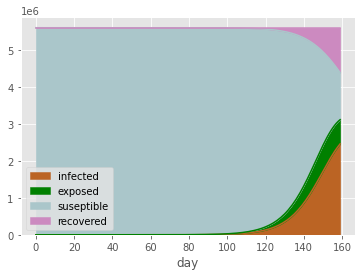

In [48]:
effective_contact_rate = 0.20294886758948968   #Paste beta from above
recovery_rate = 0.02969974213980199    #Paste gamma from above
incubation_rate = 0.20637710054200073

# We'll compute this for fun
print("R0 is", effective_contact_rate / recovery_rate)

# What's our start population look like?
# Everyone not infected or recovered is susceptible
total_pop = 5600000
recovered = 0
infected = 0
exposed = 1
susceptible = total_pop - infected - recovered - exposed

# A list of days, 0-160
days = range(0, 160)

# Use differential equations magic with our population
# We don't need to change this part of the codes.
ret = odeint(deriv,
             [susceptible, exposed, infected, recovered],
             days,
             args=(total_pop, effective_contact_rate, incubation_rate, recovery_rate))
S, E, I, R = ret.T     # all three variables S, I, R store a list of the
                    #number of people in each case from day 0 to 159

# Build a dataframe because why not
df = pd.DataFrame({
    'day': days,
    'suseptible': S,
    'exposed': E,
    'infected': I,
    'recovered': R
})

plt.style.use('ggplot')
df.plot(x='day',
        y=['infected', 'exposed', 'suseptible', 'recovered'],
        color=['#bb6424', 'green', '#aac6ca', '#cc8ac0'],
        kind='area',
        stacked=True)    #Stacked area graph is plotted when stacked=True. 
                         #Change this to stacked=False to plot a non stacking graph.

# If you get the error:
#
#     When stacked is True, each column must be either all
#     positive or negative.infected contains both...
#
# just change stacked=True to stacked=False